# Alumno: Gerardo de Miguel González

# Minería de Datos (Master en Data Science, UIMP-UC)

## S17/T03. Intercomparación de técnicas de minería de datos 

### [Profesor: Rodrigo García Manzanas]    
#### Enero 2019

## Introducción

En esta práctica/tarea haremos una intercomparación de varias de las técnicas vistas a lo largo de la asignatura: CART, k-NN, GLMs y random forests. Por tanto, pretende ser un repaso general de cara al examen en el que el objetivo es tratar de entender las ventajas y limitaciones de las distintas técnicas para un caso de aplicación particular; la predicción de precipitación.

La entrega consisitirá de un notebook de Jupyter ó un R-MarkDown, junto con el archivo html que éste genera. Ambos ficheros se entregarán a través del Moodle de la asignatura en la tarea correspondiente.

Comenzaremos cargando el dataset `meteo`, que ya ha sido utilizado en sesiones anteriores. Como ya sabéis, la variable objetivo en este dataset es la precipitation diaria en Lisboa durante el período 1979-2008, y para predecirla se dispone de 320 predictores que describen la circulación de larga escala. Dichos predictores corresponden a un conjunto de 8 variables meteorológicas
* altura geopotencial en 500 hPa
* temperatura del aire en 850 hPa, 700 hPa, 500 hPa y superficie
* humedad específica del aire en 850 hPa y 500 hPa
* presión a nivel del mar

definidas sobre un dominio geográfico que incluye 40 puntos sobre la península Ibérica.

In [1]:
#::GMG::Limpo todas las variables de memoria y cargo los datos del Github de SantanderMetGroup
## loading data
rm(list = ls())
meteo <- read.csv(url(
    'https://raw.githubusercontent.com/SantanderMetGroup/Master-Data-Science/master/Data_mining/datasets/meteo.csv')
)

In [2]:
#::GMG::Elimino la variable no informativa X
meteo$X <- NULL

In [3]:
#::GMG::Tengo el dataset completo (y + Xn ...)
head(x = meteo,n = 5)

y,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320
10.9,57042.96,56534.84,55884.40,55175.59,54458.21,56980.27,56460.59,55800.02,55051.15,⋯,101985.9,101627.3,101357.2,101110.7,101291.0,101814.9,101479.4,101164.5,100970.7,100905.3
0.6,56963.20,56493.45,55930.82,55340.20,54768.63,56856.57,56361.95,55776.76,55164.26,⋯,102048.1,102069.7,102204.5,102480.3,102858.8,101973.3,102033.3,102165.5,102323.9,102534.2
13.0,56522.59,55971.40,55304.34,54498.03,53725.15,56514.84,55977.71,55327.28,54569.78,⋯,102399.1,102448.4,102438.3,102434.3,102339.8,102669.7,102565.5,102530.3,102453.6,102487.1
0.0,54627.98,53979.80,53494.05,53072.98,52616.36,54776.17,54089.05,53516.98,53012.86,⋯,100970.0,100672.8,100360.7,100133.7,100028.4,101126.2,100700.0,100381.3,100118.3,100319.8
0.0,53584.38,53391.01,53310.38,53292.82,53340.13,53781.70,53498.13,53306.82,53213.26,⋯,100652.7,100663.5,100747.7,100934.0,101015.8,100801.6,100685.3,100777.5,100909.4,101164.7


Para agilizar los tiempos de cómputo, reduciremos la dimensionalidad de nuetro problema. Como ya se ha visto en sesiones anteriores, una alternativa para tal fin es el uso de PCs. Sin embargo, para no limitar la interpretabilidad de los resultados obtenidos con árboles, utilizaremos otra aproximación aquí. En concreto, optaremos por un análisis de correlaciones, en el que se calcula la correlación de Spearman entre nuestra variable objetivo y todas las variables predictoras disponibles. La idea es que, cuanto más fuerte sea esta correlación, mayor es el vínculo físico entre predictando y predictor, y por tanto, más útil es la información que nos aporta ese predictor. Por tanto, este análisis nos permite descartar predictores poco relevantes.
Siguiendo esta idea, calcularemos la correlación existente entre nuestro predictando y los 320 predictores, y eliminaremos aquellos con correlaciones entre -0.4 y 0.4. ¿Cuánto se ha reducido la dimensionalidad del problema?

In [4]:
#::GMG::Aplico una selección de predictores basada en la correlación de los mismos con
#       la precipitación (variable objetivo)
### informed selection of predictors, based on a correlation analysis ###
# https://stats.stackexchange.com/questions/138860/is-using-correlation-matrix-to-select-predictors-for-regression-correct
# https://www.researchgate.net/post/Should_we_select_predicting_variables_simply_with_their_correlation_with_the_dependent_variable
# https://www.researchgate.net/post/How_to_refine_MaxEnt_model_by_removing_variables_that_are_highly_correlated
r.xy <- c()
for (ivar in 2:ncol(meteo)) {
  r.xy[ivar] <- cor(meteo$y, meteo[, ivar], method = "spearman")
}

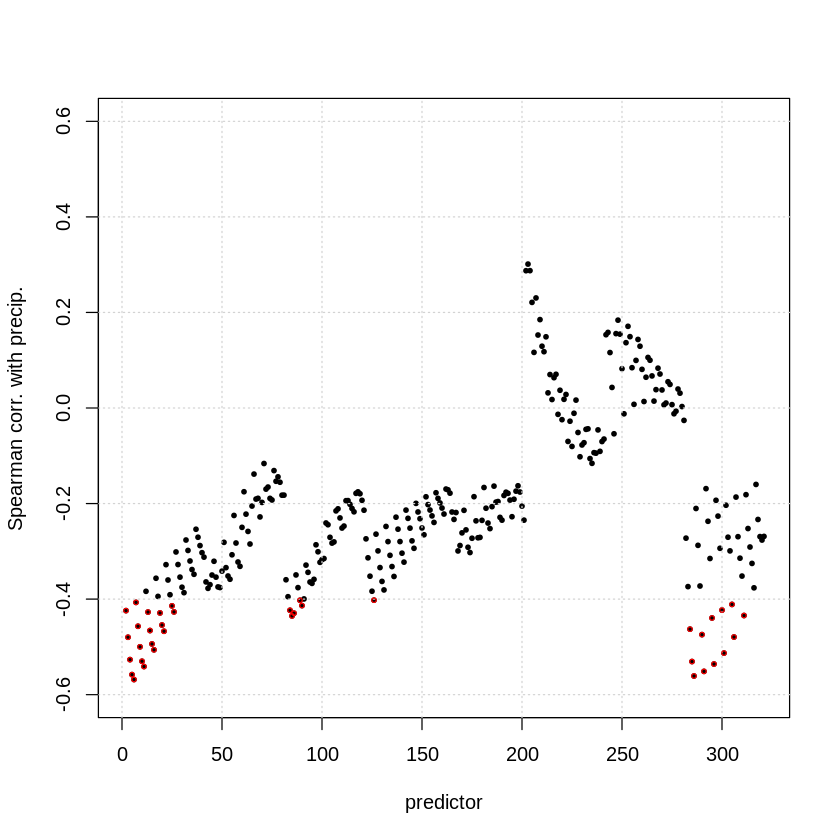

In [5]:
#::GMG::Dibujo las correlaciones de los predictores con y
plot(r.xy, 
     ylim = c(-0.6, 0.6), 
     pch = 19, cex = 0.5, 
     xlab = "predictor", 
     ylab = "Spearman corr. with precip.")
grid()
#::GMG::Hago la selección con un umbral
ind.sele <- which(abs(r.xy) > 0.4)
points(ind.sele, r.xy[ind.sele], col = "red", cex = 0.5)

In [6]:
#::GMG::Guardo el dataset (data.frame) con los predictores seleccionados
meteo_spearman <- meteo[, ind.sele]
str(meteo_spearman)

'data.frame':	10958 obs. of  37 variables:
 $ X1  : num  57043 56963 56523 54628 53584 ...
 $ X2  : num  56535 56493 55971 53980 53391 ...
 $ X3  : num  55884 55931 55304 53494 53310 ...
 $ X4  : num  55176 55340 54498 53073 53293 ...
 $ X5  : num  54458 54769 53725 52616 53340 ...
 $ X6  : num  56980 56857 56515 54776 53782 ...
 $ X7  : num  56461 56362 55978 54089 53498 ...
 $ X8  : num  55800 55777 55327 53517 53307 ...
 $ X9  : num  55051 55164 54570 53013 53213 ...
 $ X10 : num  54319 54585 53863 52501 53157 ...
 $ X12 : num  56368 56187 55965 54205 53674 ...
 $ X13 : num  55721 55587 55360 53594 53378 ...
 $ X14 : num  54946 54947 54646 53021 53200 ...
 $ X15 : num  54145 54367 53999 52451 53055 ...
 $ X18 : num  55559 55360 55339 53657 53529 ...
 $ X19 : num  54788 54690 54720 53074 53260 ...
 $ X20 : num  53973 54125 54110 52486 53065 ...
 $ X24 : num  54555 54384 54695 53144 53383 ...
 $ X25 : num  53771 53843 54135 52556 53162 ...
 $ X83 : num  272 271 271 264 264 ...
 $ X84 

Para simplificar aún más los cálculos, nos limitaremos a los primeros 5000 días del dataset. Como siempre, consideraremos una partición de la muestra en dos subconjuntos independientes, train y test, escogidos aleatoriamente (75% para entrenar y 25% para validar).

In [7]:
#::GMG::Selecciono los primeros 5000 días del dataset para simplificar cálculos
# keeping only 5000 days for this example
n <- 5000
y <- meteo$y[1:n]
x <- meteo_spearman[1:n,]
str(x)

'data.frame':	5000 obs. of  37 variables:
 $ X1  : num  57043 56963 56523 54628 53584 ...
 $ X2  : num  56535 56493 55971 53980 53391 ...
 $ X3  : num  55884 55931 55304 53494 53310 ...
 $ X4  : num  55176 55340 54498 53073 53293 ...
 $ X5  : num  54458 54769 53725 52616 53340 ...
 $ X6  : num  56980 56857 56515 54776 53782 ...
 $ X7  : num  56461 56362 55978 54089 53498 ...
 $ X8  : num  55800 55777 55327 53517 53307 ...
 $ X9  : num  55051 55164 54570 53013 53213 ...
 $ X10 : num  54319 54585 53863 52501 53157 ...
 $ X12 : num  56368 56187 55965 54205 53674 ...
 $ X13 : num  55721 55587 55360 53594 53378 ...
 $ X14 : num  54946 54947 54646 53021 53200 ...
 $ X15 : num  54145 54367 53999 52451 53055 ...
 $ X18 : num  55559 55360 55339 53657 53529 ...
 $ X19 : num  54788 54690 54720 53074 53260 ...
 $ X20 : num  53973 54125 54110 52486 53065 ...
 $ X24 : num  54555 54384 54695 53144 53383 ...
 $ X25 : num  53771 53843 54135 52556 53162 ...
 $ X83 : num  272 271 271 264 264 ...
 $ X84 :

In [8]:
str(y)

 num [1:5000] 10.9 0.6 13 0 0 1.2 1.1 0 0 0.7 ...


In [9]:
#::GMG::Hago la partición Train/Test para Cross-Validation
#::nota::pongo un seed para reproducir los resultados entre ejecuciones
#        del R Notebook
# train/test partition
set.seed(123)
indtrain <- sample(1:n, round(0.75*n))  
indtest <- setdiff(1:n, indtrain)

## Punto 1: Árboles de clasificación y regresión (CART)
### (2.5 puntos)

Como ya hemos visto en sesiones anteriores, tendremos que crear dos modelos independientes, uno para la clasificación del evento binario lluvia/no lluvia y otro para el evento continuo cantidad de lluvia.
Nos centramos en primer lugar en la clasificación lluvia/no lluvia. Para ello, tenemos que crear la variable binaria ocurrencia de precipitación (considera un umbral de 1mm) y construir el dataframe asociado al problema.

### Clasificación CART

#### Occurrence (lluvia/no lluvia)

In [10]:
#::GMG::Convierto la variable precipitación en factor con un umbral (1mm)
### binary occurrence con umbral 1 mm de precipitación ###
occurrence <- ifelse(y >= 1, 1, 0)
str(occurrence)

 num [1:5000] 1 0 1 0 0 1 1 0 0 0 ...


occurrence
   0    1 
3989 1011 

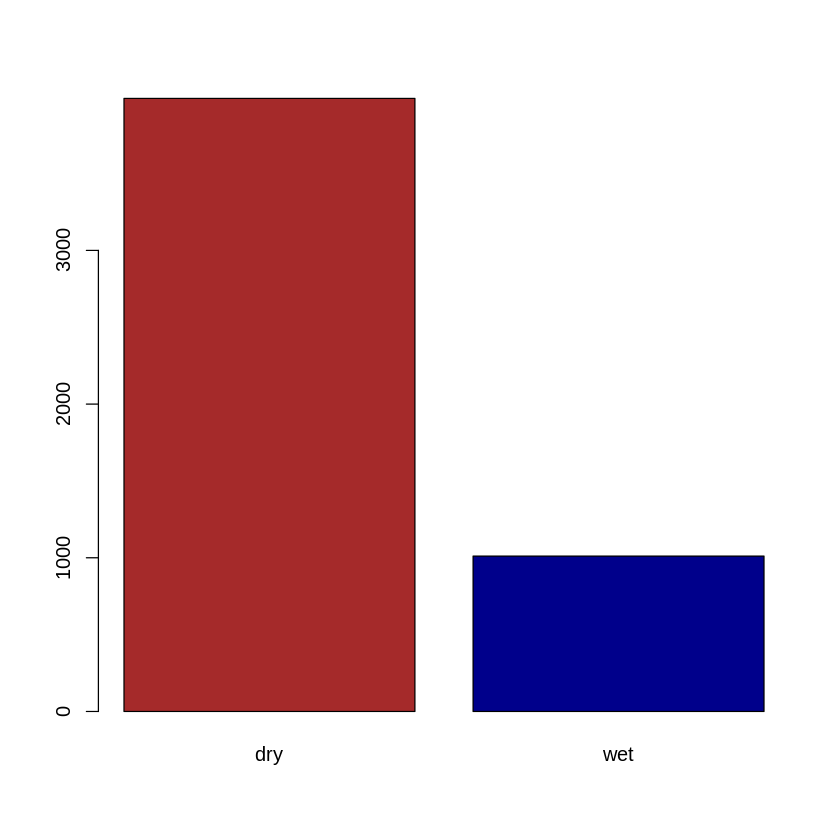

In [11]:
#::GMG::Se me ha ocurrido que puede ser interesante ver la proporción de clases en el dataset
#::nota::considero '0' días secos (dry) y '1' días lluviosos (wet)
#::nota::un 'imbalanced' dataset suele ser 'problemático' para la clasificación
#::nota::la clase 'dry' está sobre-representada en el dataset
table(occurrence)
barplot(height = table(occurrence),
        col = c('brown','darkblue'),
        names.arg = c('dry','wet'))


   0    1 
2994  756 

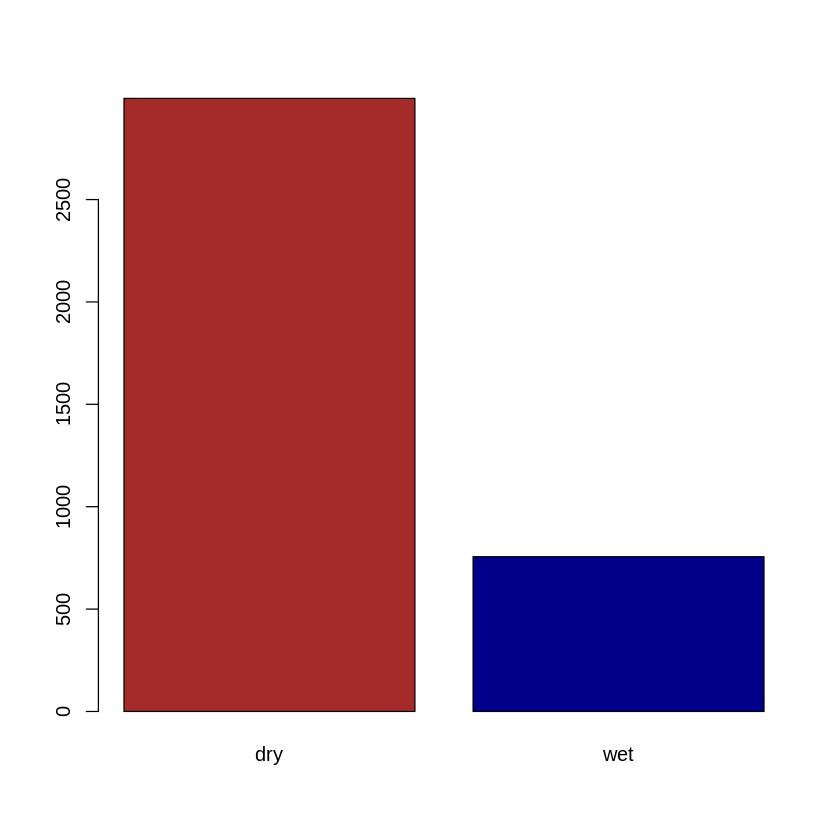

In [12]:
#::GMG::Al hacer la selección train/set puede ser interesante ver la representación
#       de las clases tras hacer la partición
#::nota::estoy puede que tenga que tenerlo en cuenta luego en los resultados de la
#        clasificación y en la validación
table(occurrence[indtrain])
barplot(height = table(occurrence[indtrain]),
        col = c('brown','darkblue'),
        names.arg = c('dry','wet'))


  0   1 
995 255 

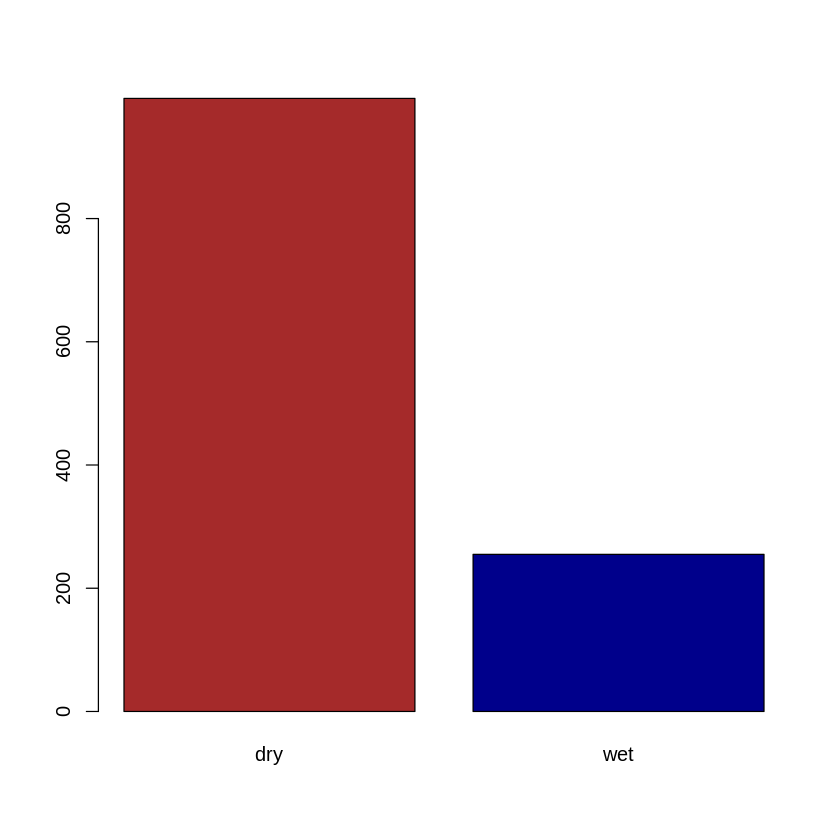

In [13]:
#::GMG::Hago lo mismo para el conjunto de test
#::nota::se ve que se mantiene la proporción del conjunto original en ambos casos
table(occurrence[indtest])
barplot(height = table(occurrence[indtest]),
        col = c('brown','darkblue'),
        names.arg = c('dry','wet'))

In [14]:
#::GMG::Monto el data.frame de ocurrencia de precipitación (lluvia/no lluvia)
# dataframe for occurrence
df_occ <- cbind(occurrence,x)
str(df_occ)

'data.frame':	5000 obs. of  38 variables:
 $ occurrence: num  1 0 1 0 0 1 1 0 0 0 ...
 $ X1        : num  57043 56963 56523 54628 53584 ...
 $ X2        : num  56535 56493 55971 53980 53391 ...
 $ X3        : num  55884 55931 55304 53494 53310 ...
 $ X4        : num  55176 55340 54498 53073 53293 ...
 $ X5        : num  54458 54769 53725 52616 53340 ...
 $ X6        : num  56980 56857 56515 54776 53782 ...
 $ X7        : num  56461 56362 55978 54089 53498 ...
 $ X8        : num  55800 55777 55327 53517 53307 ...
 $ X9        : num  55051 55164 54570 53013 53213 ...
 $ X10       : num  54319 54585 53863 52501 53157 ...
 $ X12       : num  56368 56187 55965 54205 53674 ...
 $ X13       : num  55721 55587 55360 53594 53378 ...
 $ X14       : num  54946 54947 54646 53021 53200 ...
 $ X15       : num  54145 54367 53999 52451 53055 ...
 $ X18       : num  55559 55360 55339 53657 53529 ...
 $ X19       : num  54788 54690 54720 53074 53260 ...
 $ X20       : num  53973 54125 54110 52486 53065 

In [15]:
#::GMG::Convierto la ocurrencia en un factor con dos niveles 
#::nota::clase binaria para el problema de clasificación
df_occ$occurrence <- as.factor(df_occ$occurrence)
str(df_occ)

'data.frame':	5000 obs. of  38 variables:
 $ occurrence: Factor w/ 2 levels "0","1": 2 1 2 1 1 2 2 1 1 1 ...
 $ X1        : num  57043 56963 56523 54628 53584 ...
 $ X2        : num  56535 56493 55971 53980 53391 ...
 $ X3        : num  55884 55931 55304 53494 53310 ...
 $ X4        : num  55176 55340 54498 53073 53293 ...
 $ X5        : num  54458 54769 53725 52616 53340 ...
 $ X6        : num  56980 56857 56515 54776 53782 ...
 $ X7        : num  56461 56362 55978 54089 53498 ...
 $ X8        : num  55800 55777 55327 53517 53307 ...
 $ X9        : num  55051 55164 54570 53013 53213 ...
 $ X10       : num  54319 54585 53863 52501 53157 ...
 $ X12       : num  56368 56187 55965 54205 53674 ...
 $ X13       : num  55721 55587 55360 53594 53378 ...
 $ X14       : num  54946 54947 54646 53021 53200 ...
 $ X15       : num  54145 54367 53999 52451 53055 ...
 $ X18       : num  55559 55360 55339 53657 53529 ...
 $ X19       : num  54788 54690 54720 53074 53260 ...
 $ X20       : num  53973 5

#### Árbol Completo

A continuación construiremos el árbol completo (usa la función *tree*).

**::GMG::** ¿Árbol completo? Es un árbol que clasifica perfectamente la muestra de entrenamiento (sobre el que haremos posteriormente un podado, i.e post-pruning) (s32 Overfitting: pruning the tree, presentación S07_ClassificationTrees)

**Nota**: según la documentación de [`tree.control`](https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/tree.control):

> To produce a tree that fits the data perfectly, set `mindev = 0` and `minsize = 2`, if the limit on tree depth allows such a tree.

In [16]:
#::GMG::Cargo la biblioteca tree by Brian Ripley
# https://cran.r-project.org/web/packages/tree/index.html
library(tree)

In [17]:
#::GMG::Complete tree (tree)
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/tree
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/tree.control
tree_occ_cp <- tree(occurrence ~ ., 
                   subset= indtrain,
                   data = df_occ, mindev = 0, minsize = 2)

In [18]:
#::GMG::Veo el sumario: 
#       variables usadas, número de hojas, mean dev, error rate
summary(tree_occ_cp)


Classification tree:
tree(formula = occurrence ~ ., data = df_occ, subset = indtrain, 
    mindev = 0, minsize = 2)
Variables actually used in tree construction:
 [1] "X284" "X290" "X283" "X12"  "X8"   "X1"   "X125" "X300" "X295" "X305"
[11] "X294" "X13"  "X83"  "X20"  "X304" "X84"  "X5"   "X2"   "X3"   "X285"
[21] "X24"  "X4"   "X310" "X25"  "X88"  "X6"   "X15"  "X299" "X10"  "X85" 
[31] "X18"  "X89"  "X19"  "X289" "X14"  "X7"  
Number of terminal nodes:  280 
Residual mean deviance:  0 = 0 / 3470 
Misclassification error rate: 0 = 0 / 3750 

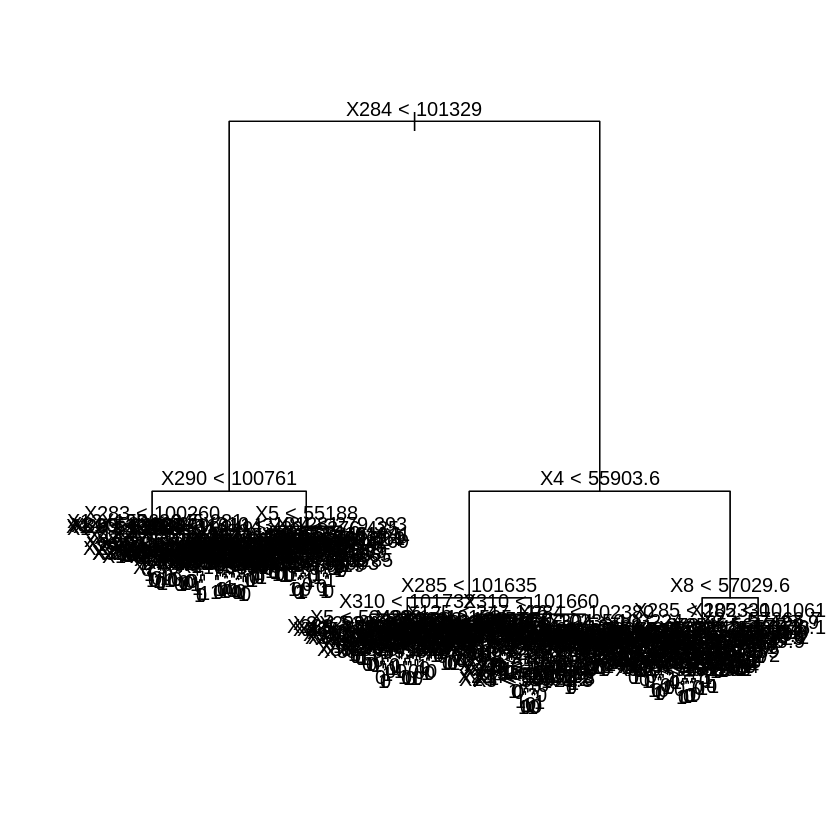

In [19]:
plot(tree_occ_cp)
text(tree_occ_cp, pretty = F)

**P1:** ¿Cuántos nodos terminales obtienes? 

In [20]:
#::GMG::count terminal nodes
# https://stackoverflow.com/questions/53208273/how-to-count-nodes-in-a-tree-in-r
paste('El número de nodos terminales es:', length(unique(tree_occ_cp$where)))

[1] "El número de nodos terminales es: 280"

**P2:** ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol?

**::GMG::** `X283`, `X284`, `X285`, `X290`, `X310` y `X4`, `X5`, `X8`. Según la descripción del dataset son los valores de "*Presión al nivel del mar*" en cinco localizaciones y  "*Altura geopotencial en 500 hPa*" en tres localizaciones, respectivamente.

**::nota::** 

    Altura geopotencial en 500 hPa (columnas 2:41),
    Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161),
    Temperatura del aire en superficie (columnas 162:201),
    Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281) y
    Presión al nivel del mar (columnas 282:321)

#### 10-fold CV y podado a posteriori

Para simplificar este árbol tan complejo tendremos que podarlo adecuadamente. Utiliza una cross-validación con un 10-fold para encontrar el número de nodos terminales del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

In [21]:
#::GMG::Hago CV reproducible
set.seed(123)

In [22]:
#::GMG::Hago la cross-validation en el conjunto de train
## 10-fold cross-validation for determining optimum number of leaves
## pruning
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/cv.tree
cv_occ <- cv.tree(object = tree_occ_cp, FUN = prune.misclass, K = 10)

In [23]:
#::GMG::Datos que puedo ver del resultado de la Cross-validation
names(cv_occ)

[1] "size"   "dev"    "k"      "method"

In [24]:
#::GMG::Vemos el resultado de la cross-validation
cv_occ

$size
 [1] 280 254 242 238 229 222 162 159 147 135 123 106  57  52  50  45  42  28  20
[20]  17  11   9   8   5   4   2   1

$dev
 [1] 561 561 561 561 561 561 560 560 560 560 560 560 560 560 560 560 560 560 560
[20] 560 560 553 554 553 551 552 756

$k
 [1]        -Inf   0.5000000   0.6666667   0.7500000   0.7777778   0.8571429
 [7]   1.0000000   1.3333333   1.5000000   1.6666667   1.7500000   1.9411765
[13]   2.0000000   2.4000000   2.5000000   2.6000000   2.6666667   2.7142857
[19]   3.0000000   4.0000000   4.6666667   5.5000000   7.0000000   8.0000000
[25]  15.0000000  23.0000000 222.0000000

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

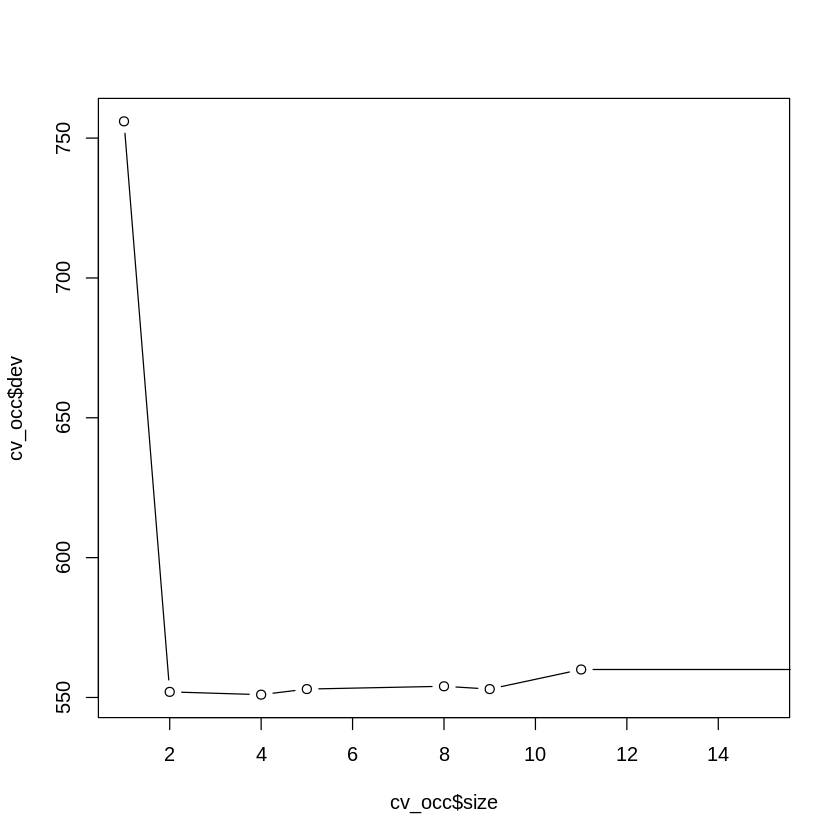

In [313]:
#::GMG::Lo veo en forma gráfica concentrándome en la zona de mínimos
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/plot.tree
# plot(cv_occ, xlim = c(1,10), ylim = c(550,560))
plot(cv_occ$size,cv_occ$dev,type='b', xlim = c(1,15))

In [34]:
paste('El tamaño óptimo de hojas es:', cv_occ$size[which.min(cv_occ$dev)])

[1] "El tamaño óptimo de hojas es: 4"

**::GMG::** De los números que salen en `$size` y `$dev` el rango de [2 10] se tiene un `$dev` muy parecido.

In [38]:
#::GMG:: Ahora lo podo
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/prune.tree
# pruned_tree_occ <- prune.tree(tree_occ_cp, best = 5, method = 'misclass')
pruned_tree_occ <- prune.misclass(tree_occ_cp, best = 4)

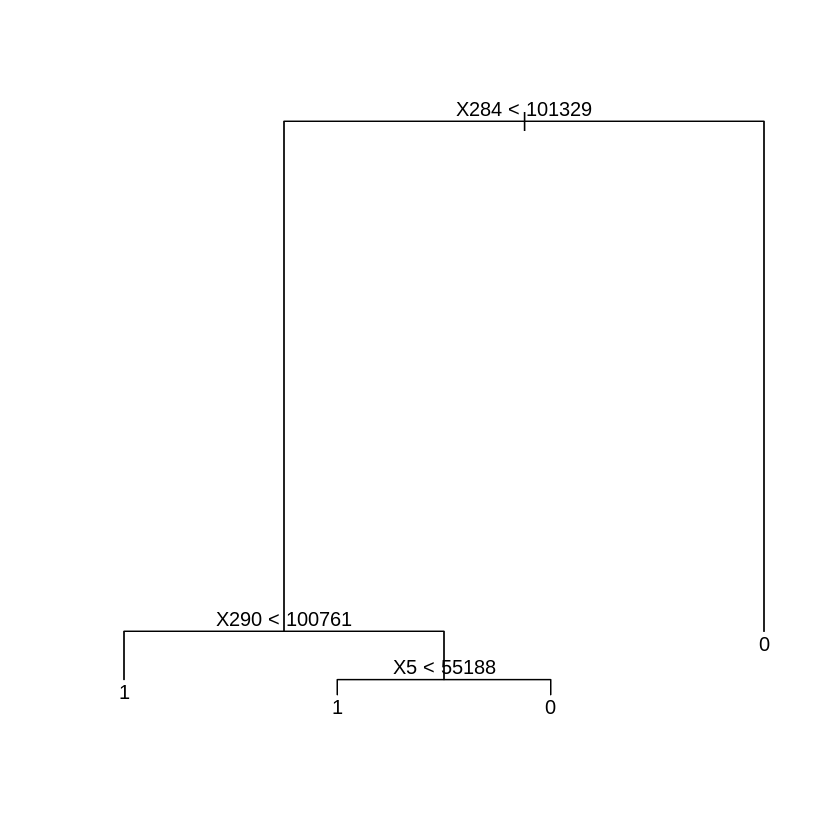

In [39]:
#::GMG::Visualizo el resultado
plot(pruned_tree_occ)
text(pruned_tree_occ, pretty = 0)

In [40]:
#::GMG::En el sumario se ven las variables que han sido utilizadas
#       misclassification error rate, residual mean deviance, ...
summary(pruned_tree_occ)


Classification tree:
snip.tree(tree = tree_occ_cp, nodes = c(4L, 11L, 3L, 10L))
Variables actually used in tree construction:
[1] "X284" "X290" "X5"  
Number of terminal nodes:  4 
Residual mean deviance:  0.7277 = 2726 / 3746 
Misclassification error rate: 0.1301 = 488 / 3750 

**::GMG::** Las variables más importantes que han sobrevivido a la poda: `X284`, `X290`, `X5`. Según la descripción del dataset son los valores de "Presión al nivel del mar" en dos localizaciones y  "Altura geopotencial en 500 hPa" en una localización, respectivamente.

**::nota::** 

    Altura geopotencial en 500 hPa (columnas 2:41),
    Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161),
    Temperatura del aire en superficie (columnas 162:201),
    Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281) y
    Presión al nivel del mar (columnas 282:321)


#### Predicción (test)

Utiliza este árbol óptimo para predecir en el test. Guarda las predicciones.

In [44]:
#::GMG::Hago la predicción para el conjunto de test (occurrence prediction for test)
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/predict.tree
pred_occ <- predict(object = pruned_tree_occ, newdata = df_occ[indtest,], type="class")

In [45]:
str(pred_occ)

 Factor w/ 2 levels "0","1": 1 1 2 2 2 2 2 2 2 2 ...


In [99]:
#::GMG::Además de guardar la predicción puedo ver cómo es esa predicción
#       en términos de la tabla de contingencia
### Confusion Matrix to check number of Misclassifications ###
t_occ <- with(df_occ[indtest,],table(pred_occ,occurrence))
print(t_occ)

        occurrence
pred_occ   0   1
       0 925 125
       1  70 130


In [51]:
## Misclassification Error Rate on Test Set ##
error_occ <- mean(pred_occ != df_occ[indtest,]$occurrence)
paste('Misclassification Error Rate (Test):', 100*error_occ, '%')

[1] "Misclassification Error Rate (Test): 15.6 %"

In [52]:
## Accuracy on Test Set (1 - Misclassification error rate) ##
accuracy_occ <- sum(
    diag(table(pred_occ,df_occ[indtest,]$occurrence))
)/length(df_occ[indtest,]$occurrence)
paste('Accuracy (Test):', 100*accuracy_occ, '%')

[1] "Accuracy (Test): 84.4 %"

In [308]:
#::GMG::Me pregunto si estoy en zona de overfitting o underfitting
#       Hago una pequeña exploración de árboles dentro de la 'zona del óptimo'
#       que deduce con el podado con CV
#       (mejor con random forest, claro :)
acc_train <- c()
acc_test <- c()
for (size in 2:15) {
    t <- prune.misclass(tree_occ_cp, best = size)
    p_train <- predict(object = t, newdata = df_occ[indtrain,], type="class")
    acc_train[size] <- sum(
                            diag(table(p_train,df_occ[indtrain,]$occurrence))
                          )/length(df_occ[indtrain,]$occurrence)
    p_test <- predict(object = t, newdata = df_occ[indtest,], type="class")
    acc_test[size] <- sum(
                            diag(table(p_test,df_occ[indtest,]$occurrence))
                          )/length(df_occ[indtest,]$occurrence)
}

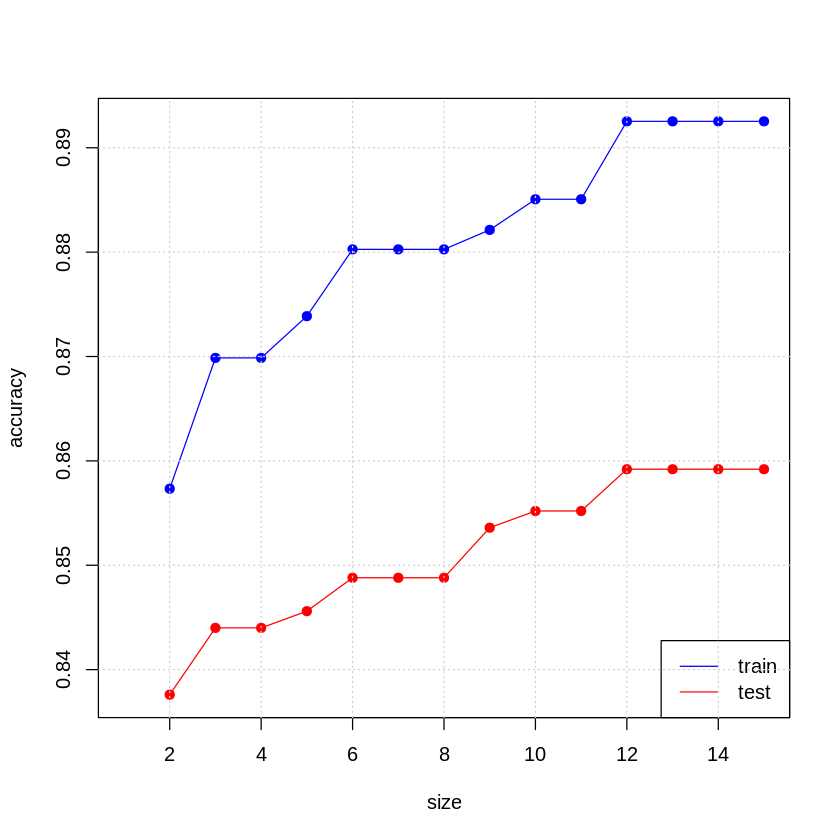

In [312]:
#::GMG::Dibujo el resultado
#par(mfrow = c(1,2))
matplot(cbind(acc_train, acc_test), 
        type = "o", pch = 19, lty = 1, 
        col = c("blue", "red"),
xlab = "size", ylab = "accuracy")
legend("bottomright", c("train", "test"),
       lty = 1, 
       col = c("blue", "red")
      )
grid()
#::GMG::Dibujo el resultado también con error
#matplot(cbind(1 - acc_train, 1 - acc_test), 
#        type = "o", pch = 19, lty = 1, 
#        col = c("blue", "red"),
#xlab = "size", ylab = "misclassification error")
#legend("bottomleft", c("train", "test"),
#       lty = 1, 
#       col = c("blue", "red")
#      )
#grid()

**::GMG::** Parece que 12 es el tamaño a partir de cual ya no hay mejora. La mejora de 4 a 12 no es muy grande, apenas un 2%. Mantengo mi árbol de tamaño 4.

### Regresión CART

#### Intensidad

Una vez obtenidas las predicciones de ocurrencia pasaremos a estimar la cantidad de precipitación. Primero creamos el dataset correspondiente.

In [53]:
#::GMG::Monto el dataset para amount
## dataframe for amount
#::nota::mantengo los índices de train/test
df_amount <- cbind(y,x)
str(df_amount)

'data.frame':	5000 obs. of  38 variables:
 $ y   : num  10.9 0.6 13 0 0 1.2 1.1 0 0 0.7 ...
 $ X1  : num  57043 56963 56523 54628 53584 ...
 $ X2  : num  56535 56493 55971 53980 53391 ...
 $ X3  : num  55884 55931 55304 53494 53310 ...
 $ X4  : num  55176 55340 54498 53073 53293 ...
 $ X5  : num  54458 54769 53725 52616 53340 ...
 $ X6  : num  56980 56857 56515 54776 53782 ...
 $ X7  : num  56461 56362 55978 54089 53498 ...
 $ X8  : num  55800 55777 55327 53517 53307 ...
 $ X9  : num  55051 55164 54570 53013 53213 ...
 $ X10 : num  54319 54585 53863 52501 53157 ...
 $ X12 : num  56368 56187 55965 54205 53674 ...
 $ X13 : num  55721 55587 55360 53594 53378 ...
 $ X14 : num  54946 54947 54646 53021 53200 ...
 $ X15 : num  54145 54367 53999 52451 53055 ...
 $ X18 : num  55559 55360 55339 53657 53529 ...
 $ X19 : num  54788 54690 54720 53074 53260 ...
 $ X20 : num  53973 54125 54110 52486 53065 ...
 $ X24 : num  54555 54384 54695 53144 53383 ...
 $ X25 : num  53771 53843 54135 52556 53162 

A continuación construiremos dos árboles, uno entrenado sobre todo el conjunto de train y otro entrenado sólo sobre los días de lluvia (en el train). 

#### Árbol Completo en todo el conjunto de train

Empezamos por el primero de estos árboles. Construye el árbol completo ¿Cuántos nodos terminales obtienes? ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol? ¿Son las mismas que para el caso de la ocurrencia?

In [54]:
#::GMG::Construyo el árbol completo sobre todo el train (llueva o no)
## complete tree 1
#::nota::recordar lo que dice la documentación de tree.control para
#        poner bien los parámetros
tree_amount_all_cp <- tree(y ~ ., 
                   subset= indtrain,
                   data = df_amount, mindev = 0, minsize = 2)

In [55]:
summary(tree_amount_all_cp)


Regression tree:
tree(formula = y ~ ., data = df_amount, subset = indtrain, mindev = 0, 
    minsize = 2)
Number of terminal nodes:  922 
Residual mean deviance:  0.003691 = 10.44 / 2828 
Distribution of residuals:
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.2667000 -0.0033330 -0.0006983  0.0000000  0.0000000  0.3000000 

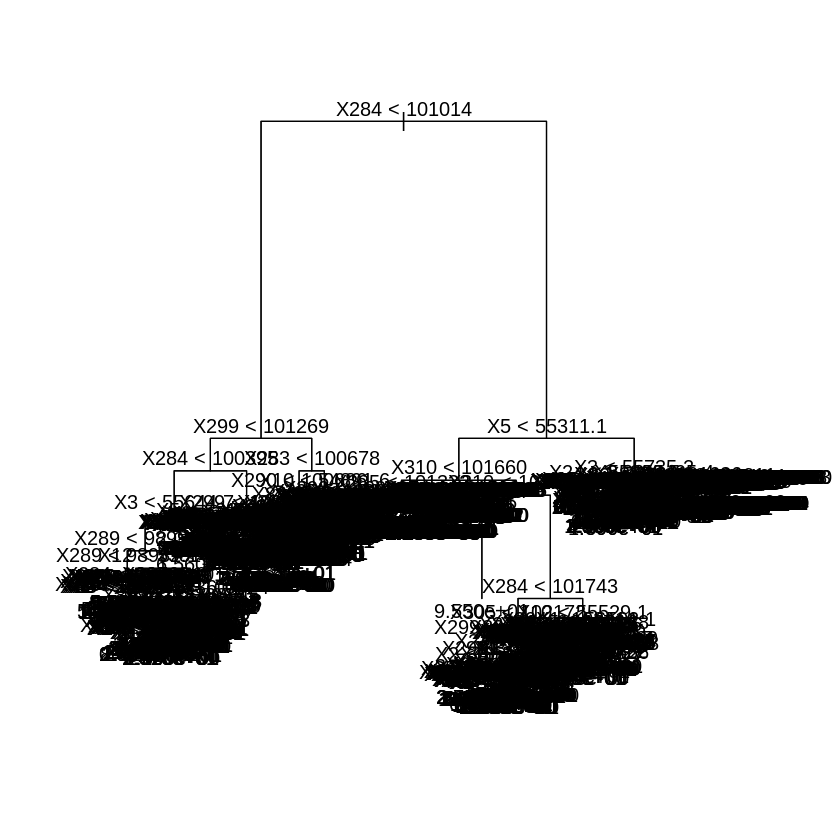

In [56]:
plot(tree_amount_all_cp)
text(tree_amount_all_cp, pretty = F)

In [57]:
paste('El número de nodos terminales es:', length(unique(tree_amount_all_cp$where)))

[1] "El número de nodos terminales es: 922"

**::GMG::** Las primeras subdivisiones del árbol usan las siguientes variables predictoras: X284, X289, X299, X310 y X3, X5. Según la descripción del dataset son los valores de "Presión al nivel del mar" en cuatro localizaciones y  "Altura geopotencial en 500 hPa" en dos localizaciones, respectivamente. Parece que se ha dado más "peso" a la *presión a nivel del mar* en este caso.

**::nota::**:

    Altura geopotencial en 500 hPa (columnas 2:41),
    Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161),
    Temperatura del aire en superficie (columnas 162:201),
    Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281) y
    Presión al nivel del mar (columnas 282:321)


#### 10-fold CV y podado a posteriori

Al igual que hicimos para el caso de la ocurrencia, tendremos que podar este árbol tan complejo. Utiliza una cross-validación con un 10-fold para encontrar el número de nodos terminales del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

In [58]:
#::GMG::Hago CV reproducible
set.seed(123)

In [59]:
#::GMG::Hago la cross-validation en el conjunto de train
## 10-fold cross-validation for determining optimum number of leaves
## pruning
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/cv.tree
cv_amount <- cv.tree(object = tree_amount_all_cp, FUN = prune.tree, K = 10)

In [60]:
paste('El tamaño óptimo de hojas es:', cv_amount$size[which.min(cv_amount$dev)])

[1] "El tamaño óptimo de hojas es: 7"

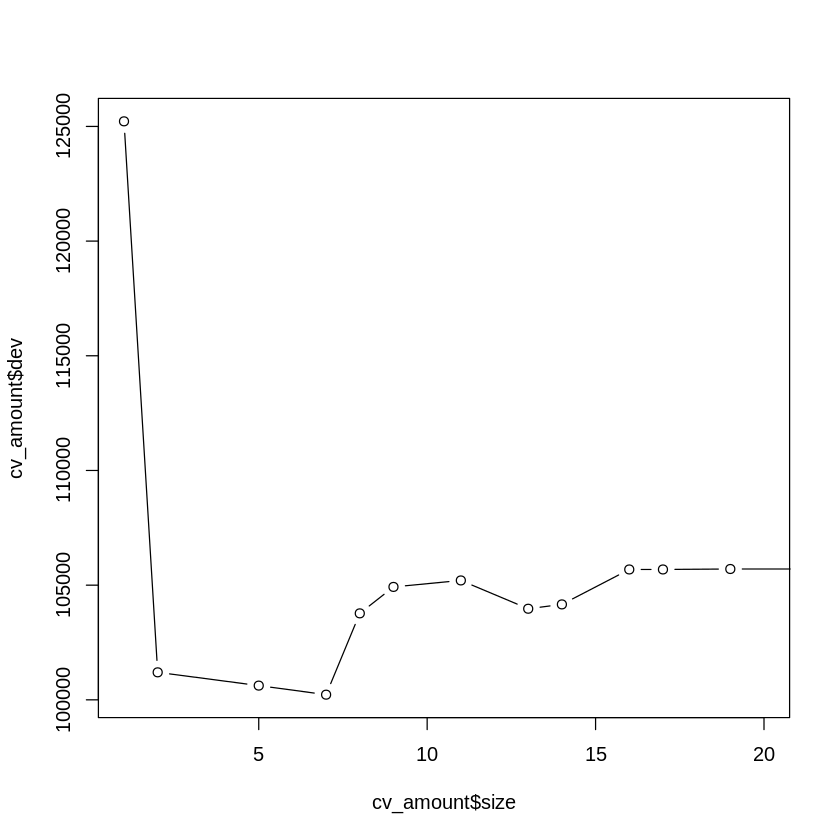

In [62]:
#::GMG::Lo veo gráficamente
#plot(cv_amount, xlim =c(1,20) , ylim = c(100000, 105000))
plot(cv_amount$size,cv_amount$dev,type='b', xlim =c(1,20))

In [63]:
#::GMG:: Ahora lo podo con el 'mejor' tamaño elegido por CV
pruned_tree_amount_all <- prune.tree(tree_amount_all_cp, best = 7)

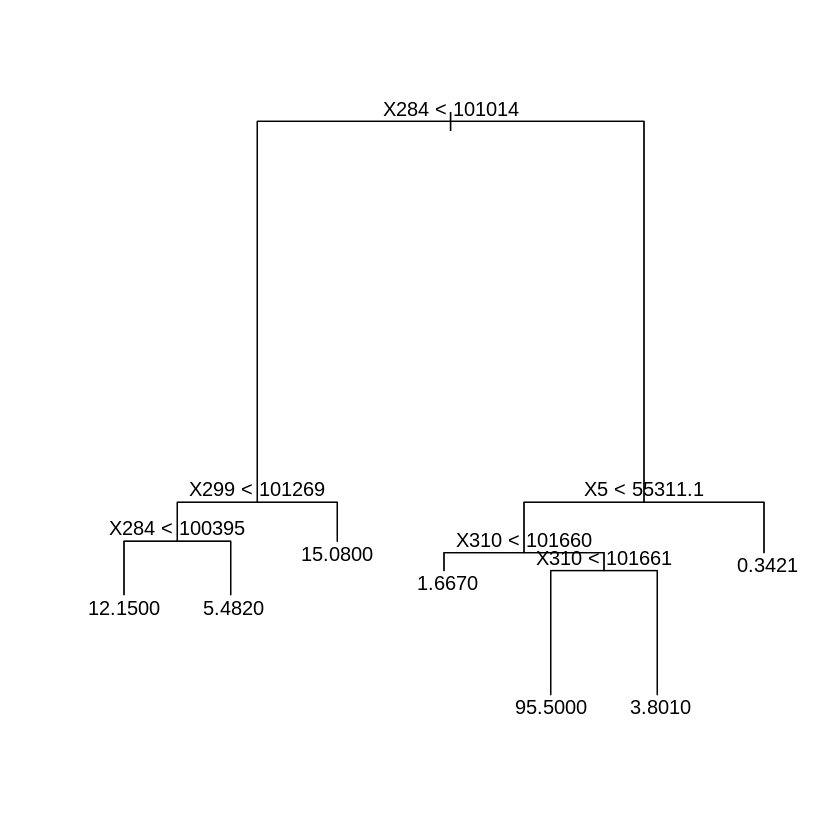

In [64]:
#::GMG::Visualizo el resultado
plot(pruned_tree_amount_all)
text(pruned_tree_amount_all, pretty = 0)

In [65]:
#::GMG::En el sumario se ven las variables que han sido utilizadas
summary(pruned_tree_amount_all)


Regression tree:
snip.tree(tree = tree_amount_all_cp, nodes = c(12L, 7L, 9L, 5L, 
27L, 8L))
Variables actually used in tree construction:
[1] "X284" "X299" "X5"   "X310"
Number of terminal nodes:  7 
Residual mean deviance:  21.41 = 80150 / 3743 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-15.0800  -0.3421  -0.3421   0.0000  -0.3421  53.4500 

**::GMG::** Las variables más importantes que han sobrevivido a la poda: `X310`, `X284`, `X299`, `X5`. Según la descripción del dataset son los valores de "Presión al nivel del mar" en tres localizaciones (se ha caído una tras la poda) y  "Altura geopotencial en 500 hPa" en una localización (se ha caído una tras la poda), respectivamente.

**::nota::** 

    Altura geopotencial en 500 hPa (columnas 2:41),
    Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161),
    Temperatura del aire en superficie (columnas 162:201),
    Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281) y
    Presión al nivel del mar (columnas 282:321)


#### Predicción (test)

Utiliza el árbol óptimo que acabas de encontrar para predecir en el test, y conserva la predicción obtenida.

In [66]:
#::GMG::Hago la predicción para el conjunto de test (amount prediction for test)
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/predict.tree
pred_amount <- predict(object = pruned_tree_amount_all, 
                       newdata = df_amount[indtest,])

In [67]:
str(pred_amount)

 Named num [1:1250] 1.667 0.342 12.154 5.482 5.482 ...
 - attr(*, "names")= chr [1:1250] "1" "7" "19" "24" ...


In [213]:
#::GMG::Calculo métricas de error para discusión posterior
#::nota::hay dudas sobre el valor e R2 para valorar el goodness of fit y el (R)MSE
# https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/10/lecture-10.pdf
#SSE_amount_all <- sum((df_amount$y[indtest] - pred_amount)^2)
#SST_amount_all <- sum((df_amount$y[indtest] - mean(df_amount$y[indtest]))^2)
RMSE_amount_all <- sqrt(mean((df_amount$y[indtest] - pred_amount)^2))
#R2_amount_all <- 1 - SSE_amount_all/SST_amount_all
paste('RMSE (Test):', round(RMSE_amount_all,2)#,
      #'// R2 (Test):', round(R2_amount_all,2)
     )

[1] "RMSE (Test): 5.42"

In [224]:
#::GMG::Caculo de la correlación entre predicción y muestra
cor_amount_all <- cor(pred_amount, df_amount$y[indtest], method='spearman')
paste('Spearman:', round(cor_amount_all,2))

[1] "Spearman: 0.54"

In [260]:
#::GMG::Métrica de ratio de varianzas
rv_amount_all <- var(pred_amount) / var(df_amount$y[indtest])
paste('Ratio Varianzas:', round(rv_amount_all,2))

[1] "Ratio Varianzas: 0.54"

In [261]:
#::GMG::Resumen Test dataset amount
cbind(RMSE_amount_all, cor_amount_all, rv_amount_all)

RMSE_amount_all,cor_amount_all,rv_amount_all
5.424795,0.5357675,0.5403199


#### Árbol completo solo días de lluvia

Repite el mismo proceso para el segundo árbol de regresión (el que sólo se entrena sobre los días de lluvia en el train).

In [343]:
#::GMG::Ahora voy a usar solamente los días de lluvia
#::nota::Aquí considero df_rainy como un subconjunto de df_amount y luego
#        hago una nueva partición train/test para entrenar un árbol óptimo con cv
#::DUDA::El problema con esta aproximación es que luego para calcular la 
#        'serie completa' para el test no tiene sentido considerar la ocurrencia
#        porque el tamaño de los datasets va a ser diferente (se han quitado los 
#        ceros, es decir, los días secos)
#rainy <- y*occurrence
#rain <- rainy[-which(rainy == 0)]
#df_rainy <- cbind(rain, x[which(occurrence == 1),])
#str(df_rainy)
#::GMG::Hago train/test reproducible
#set.seed(123)
#::GMG::Hago la NUEVA partición Train/Test para Cross-Validation
# train/test partition
#::nota::ya no tenemos 5000 samples ... tenemos 1011 ;)
#indtrain_rainy <- sample(1:nrow(df_rainy), round(0.75*nrow(df_rainy)))  
#indtest_rainy <- setdiff(1:nrow(df_rainy), indtrain)
#::nota::Lo que decido hacer es interpretar literalmente el enunciado
#        'el que sólo se entrena sobre los días de lluvia en el train'
# https://stackoverflow.com/questions/4935479/how-to-combine-multiple-conditions-to-subset-a-data-frame-using-or
# nrow((df_amount[indtrain,])[which(df_amount$y[indtrain] >= 1),])
nrow(subset(df_amount[indtrain,], df_amount$y[indtrain] >= 1))

[1] 756

In [342]:
#::GMG::Repito el proceso de 'refinado' de árbol completo
## complete tree 2 (trained only on rainy days)
tree_amount_rainy_cp <- tree(y ~ ., 
                   subset = df_amount$y[indtrain] >= 1,
                   data = df_amount[indtrain,], 
                   mindev = 0, minsize = 2)

In [344]:
summary(tree_amount_rainy_cp)


Regression tree:
tree(formula = y ~ ., data = df_amount[indtrain, ], subset = df_amount$y[indtrain] >= 
    1, mindev = 0, minsize = 2)
Number of terminal nodes:  593 
Residual mean deviance:  0.01767 = 2.88 / 163 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.1667  0.0000  0.0000  0.0000  0.0000  0.1800 

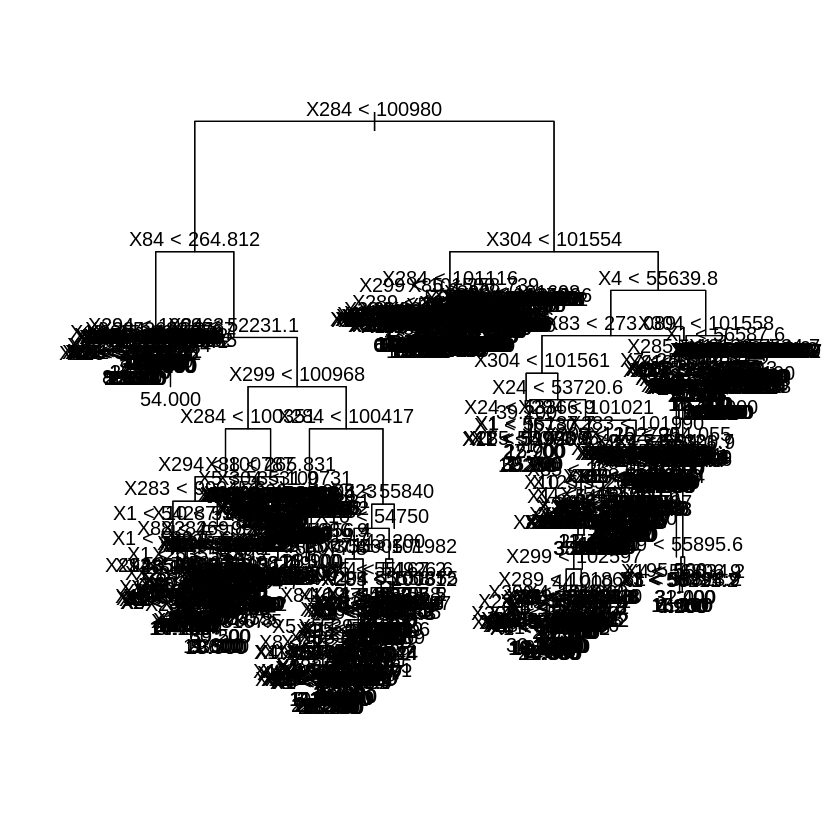

In [345]:
plot(tree_amount_rainy_cp)
text(tree_amount_rainy_cp, pretty = F)

In [346]:
paste('El número de nodos terminales es:', length(unique(tree_amount_rainy_cp$where)))

[1] "El número de nodos terminales es: 593"

#### 10-fold CV y podado a posteriori

In [347]:
#::GMG::Hago CV reproducible
set.seed(123)

In [348]:
## 10-fold cross-validation for determining optimum number of leaves
cv_amount_rainy <- cv.tree(object = tree_amount_rainy_cp, FUN = prune.tree, K = 10)

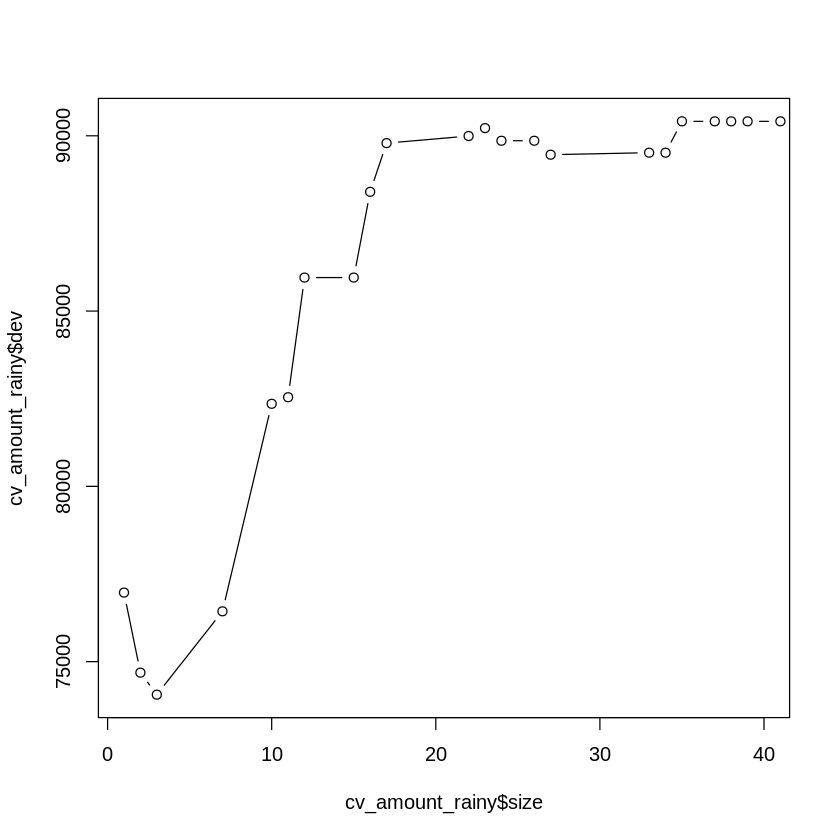

In [349]:
# plot(cv_amount_rainy, xlim = c(1,40))
plot(cv_amount_rainy$size,cv_amount_rainy$dev,type='b', xlim = c(1,40))

In [350]:
paste('El tamaño óptimo de hojas es:', cv_amount_rainy$size[which.min(cv_amount_rainy$dev)])

[1] "El tamaño óptimo de hojas es: 3"

In [351]:
#::GMG:: Ahora lo podo
#::nota::el valor óptimo tal vez sea demasiado "simple" y estemos en "bajoajuste"
pruned_tree_amount_rainy <- prune.tree(tree_amount_rainy_cp, best = 3)

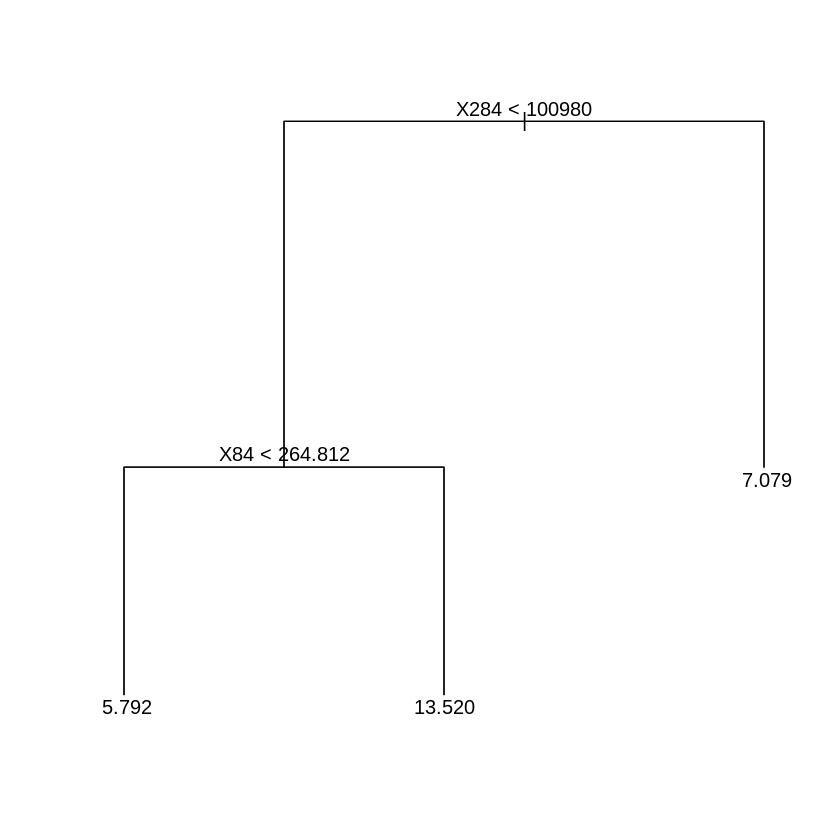

In [352]:
#::GMG::Visualizo el resultado
plot(pruned_tree_amount_rainy)
text(pruned_tree_amount_rainy, pretty = 0)

In [353]:
#::GMG::En el sumario se ven las variables que han sido utilizadas
summary(pruned_tree_amount_rainy)


Regression tree:
snip.tree(tree = tree_amount_rainy_cp, nodes = c(4L, 5L, 3L))
Variables actually used in tree construction:
[1] "X284" "X84" 
Number of terminal nodes:  3 
Residual mean deviance:  91.56 = 68950 / 753 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-12.520  -5.479  -2.849   0.000   2.688  88.420 

#### Predicción (test)

In [354]:
#::GMG::Hago la predicción
## amount prediction for test
#pred_amount_rainy <- predict(object = pruned_tree_amount_rainy, 
#                             newdata = df_rainy[indtest_rainy,])
#::nota::ahora supongo que se refiere al test del conjunto completo y no 
#        al subconjunto del conjunto de test que solamente tiene días
#        de lluvia
#::DUDA::No sé si esto es correcto pero es la única manera de obtener
#        luego en la validación una 'serie completa' combinandola con la
#        serie de ocurrencia
#pred_amount_rainy <- predict(object = pruned_tree_amount_rainy, 
#                             newdata = subset(df_amount[indtest,], df_amount$y[indtest] >= 1)
#                             )
pred_amount_rainy <- predict(object = pruned_tree_amount_rainy, 
                             newdata = df_amount[indtest,])

In [355]:
#::GMG::Calculo métricas de error para discusión posterior
#RMSE_amount_rainy <- sqrt(mean((df_rainy$rain[indtest_rainy] - pred_amount_rainy)^2))
RMSE_amount_rainy <- sqrt(mean((df_amount$y[indtest] - pred_amount_rainy)^2))
paste('Solo lluvia RMSE (Test):', round(RMSE_amount_rainy,2))

[1] "Solo lluvia RMSE (Test): 7.58"

In [358]:
#cor_amount_rainy <- cor(pred_amount_rainy, df_rainy$rain[indtest_rainy], method = 'spearman')
cor_amount_rainy <- cor(df_amount$y[indtest], pred_amount_rainy,  method = 'spearman')
paste('Solo lluvia Spearman:', round(cor_amount_rainy,2))

[1] "Solo lluvia Spearman: 0.29"

In [357]:
#::GMG::Métrica de ratio de varianzas
#::DUDA::aquí se aprecia un 'underfit' (?)
rv_amount_rainy <- var(pred_amount_rainy) / var(df_amount$y[indtest])
paste('Ratio Varianzas:', round(rv_amount_rainy,2))

[1] "Ratio Varianzas: 0.11"

In [359]:
#::GMG::Resumen Test dataset amount solo lluvia óptimo
cbind(RMSE_amount_rainy, cor_amount_rainy, rv_amount_rainy)

RMSE_amount_rainy,cor_amount_rainy,rv_amount_rainy
7.577443,0.2901627,0.1147951


In [360]:
#::GMG::Pruebo un árbol más complejo del siguiente mínimo local en size
pruned_tree_amount_rainy_b <- prune.tree(tree_amount_rainy_cp, best = 10)
summary(pruned_tree_amount_rainy_b)


Regression tree:
snip.tree(tree = tree_amount_rainy_cp, nodes = c(4L, 6L, 15L, 
28L, 59L, 47L, 46L, 22L))
Variables actually used in tree construction:
[1] "X284" "X84"  "X24"  "X299" "X304" "X4"   "X83"  "X7"  
Number of terminal nodes:  10 
Residual mean deviance:  71.25 = 53150 / 746 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-23.530  -4.396  -2.252   0.000   2.801  51.000 

In [361]:
pred_amount_rainy_b <- predict(object = pruned_tree_amount_rainy_b, 
                                newdata = df_amount[indtest,])

In [362]:
#::GMG::Se aprecia una mejora en el ratio de varianza
RMSE_amount_rainy_b <- sqrt(mean((pred_amount_rainy_b - df_amount$y[indtest])^2))
paste('Solo lluvia Size 10 RMSE (Test):', round(RMSE_amount_rainy_b,2))
cor_amount_rainy_b <- cor(pred_amount_rainy_b, df_amount$y[indtest], method = 'spearman')
paste('Solo lluvia Size 10 Spearman:', round(cor_amount_rainy_b,2))
#::GMG::Métrica de ratio de varianzas
rv_amount_rainy_b <- var(pred_amount_rainy_b) / var(df_amount$y[indtest])
paste('Ratio Varianzas Size 10:', round(rv_amount_rainy_b,2))

[1] "Solo lluvia Size 10 RMSE (Test): 7.32"

[1] "Solo lluvia Size 10 Spearman: 0.21"

[1] "Ratio Varianzas Size 10: 0.51"

In [363]:
#::GMG::Resumen Test dataset amount solo lluvia "siguiente óptimo"
#::nota::me quedo con este árbol :)
cbind(RMSE_amount_rainy_b, cor_amount_rainy_b, rv_amount_rainy_b)

RMSE_amount_rainy_b,cor_amount_rainy_b,rv_amount_rainy_b
7.316613,0.2089672,0.5118578


### Validación

Obtén las dos series predichas completas para el test (la secuencia lluvia/no lluvia será la misma en las dos) y valida tus resultados en función de las siguiente métricas: 
* Para la parte binaria lluvia/no lluvia: Accuracy.
* Para la serie completa: RMSE, correlación de Spearman y ratio de varianzas.

#### Serie Completa (lluvia/no lluvia)

In [368]:
## final prediction
# https://stackoverflow.com/questions/3418128/how-to-convert-a-factor-to-integer-numeric-without-loss-of-information/
pred_final_cp <- as.numeric(as.character(pred_occ)) * pred_amount

In [370]:
#::GMG::Calculo métricas
RMSE_amount_final <- sqrt(mean((df_amount$y[indtest] - pred_final_cp)^2))
paste('RMSE Final:', round(RMSE_amount_final,2))

cor_amount_final <- cor(df_amount$y[indtest], pred_final_cp,  method = 'spearman')
paste('Spearman Final:', round(cor_amount_final,2))

rv_amount_final <- var(pred_final_cp) / var(df_amount$y[indtest])
paste('Ratio Varianzas Final :', round(rv_amount_final,2))

[1] "RMSE Final: 4.76"

[1] "Spearman Final: 0.53"

[1] "Ratio Varianzas Final : 0.28"

In [371]:
#::GMG::Resumen Test dataset amount
cbind(RMSE_amount_final, cor_amount_final, rv_amount_final)

RMSE_amount_final,cor_amount_final,rv_amount_final
4.763387,0.5286241,0.2841801


#### Serie Completa (Solo lluvia)

In [372]:
pred_final_rainy <-  as.numeric(as.character(pred_occ)) * pred_amount_rainy_b

In [536]:
#::GMG::Calculo métricas
RMSE_final_rainy <- sqrt(mean((df_amount$y[indtest] - pred_final_rainy)^2))
paste('Solo lluvia RMSE (Test):', round(RMSE_final_rainy,2))

cor_final_rainy <- cor(df_amount$y[indtest], pred_final_rainy,  method = 'spearman')
paste('Solo lluvia Spearman:', round(cor_final_rainy,2))

rv_final_rainy <- var(pred_final_rainy) / var(df_amount$y[indtest])
paste('Ratio Varianzas:', round(rv_final_rainy,2))

[1] "Solo lluvia RMSE (Test): 4.88"

[1] "Solo lluvia Spearman: 0.53"

[1] "Ratio Varianzas: 0.58"

In [535]:
#::GMG::Resumen Test dataset amount
cbind(RMSE_final_rainy, cor_final_rainy, rv_final_rainy)

RMSE_final_rainy,cor_final_rainy,rv_final_rainy
4.883607,0.5263696,0.5809775


#### Ocurrencia (Clasificación Lluvia/No Lluvia)

In [100]:
#::GMG::Las predicciones que he obtenido
## final prediction occurrece (lluvia/no lluvia)
str(pred_occ)
print(t_occ)
paste('Occurence Misclassification Error Rate (Test):', 100*error_occ, '%')
paste('Occurrence Accuracy (Test):', 100*accuracy_occ, '%')

 Factor w/ 2 levels "0","1": 1 1 2 2 2 2 2 2 2 2 ...
        occurrence
pred_occ   0   1
       0 925 125
       1  70 130


[1] "Occurence Misclassification Error Rate (Test): 15.6 %"

[1] "Occurrence Accuracy (Test): 84.4 %"

#### Más cosas

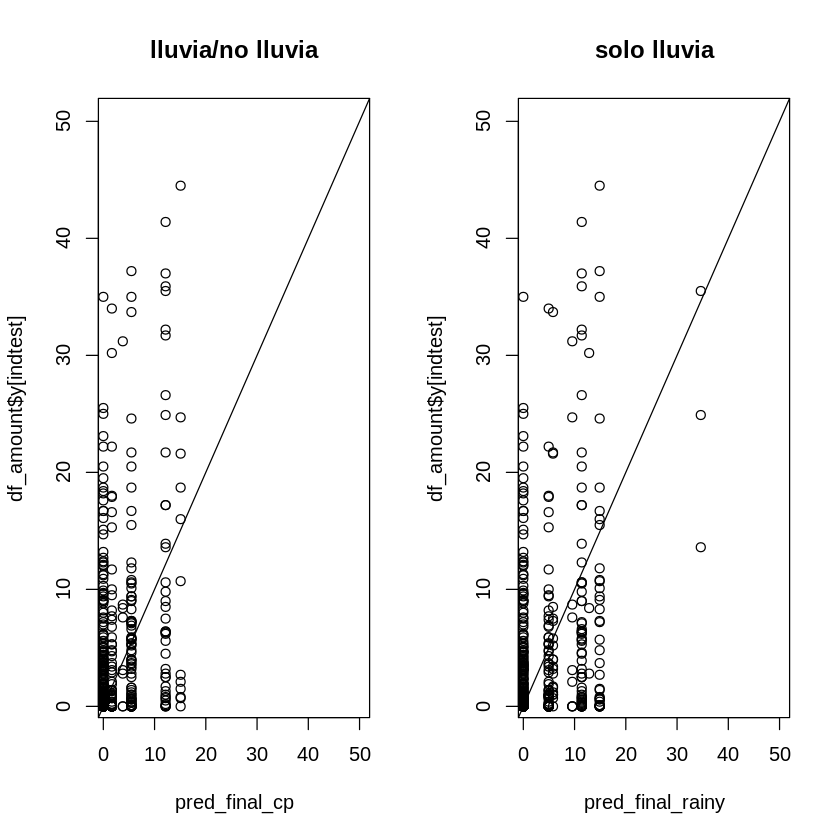

In [381]:
#::GMG::Veo cómo de buena es la predicción gráficamente
par(mfrow = c(1,2))
plot(pred_final_cp,df_amount$y[indtest], 
     xlim = c(1,50), ylim = c(1,50),
     main = 'lluvia/no lluvia')

abline(0,1)
plot(pred_final_rainy,df_amount$y[indtest], 
     xlim = c(1,50), ylim = c(1,50),
     main = 'solo lluvia')
abline(0,1)

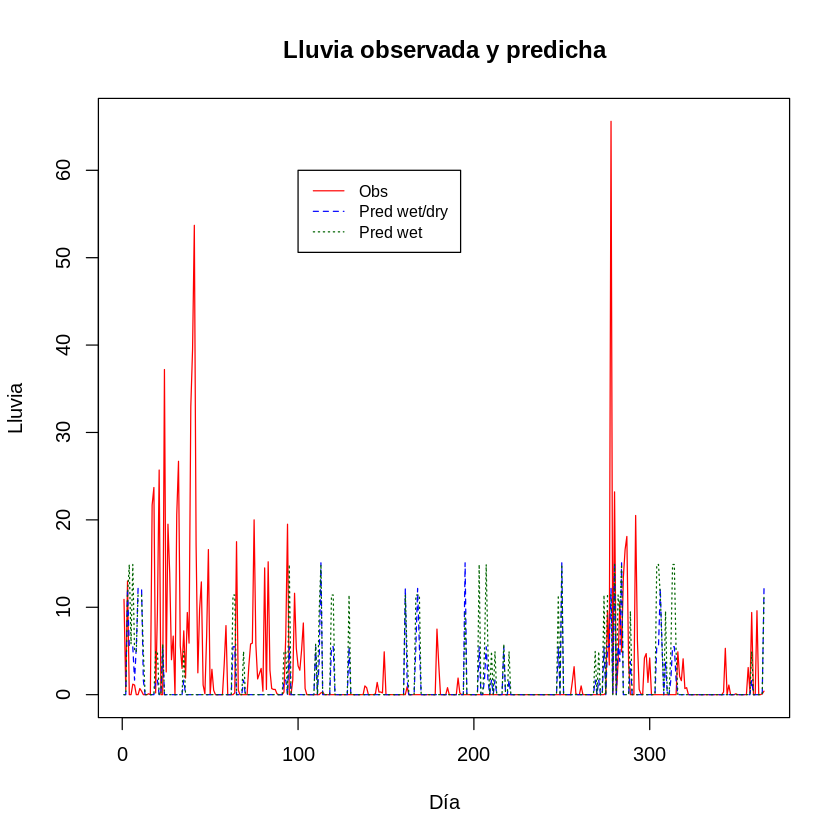

In [383]:
#::GMG::Ejemplo de lluvia observada y predicha (365 primeros días)
plot(df_amount$y[1:365], type = "l",col = "red", 
     xlab = "Día", lty = 1, ylab = "Lluvia", 
     main = "Lluvia observada y predicha")
lines(pred_final_cp[1:365], 
      type = "l", lty = 2, col = "blue")
lines(pred_final_rainy[1:365], 
      type = "l", lty = 3, col = "darkgreen")
legend(100, 60, legend=c("Obs", "Pred wet/dry", "Pred wet"),
       col=c("red", "blue", "darkgreen"), lty=1:3, cex=0.8)

### Conclusiones

**Pregunta:** ¿Cuál de los dos árboles da mejores resultados? ¿Por qué?

**::GMG::** Repaso un poco el trabajo realizado en este punto. He utilizado CART para modelar el evento lluvia/no  lluvia (clasificación) y la predicción de la intensidad de lluvia (regresión). El dataset utilizado tiene un mal balance en representación de los eventos lluva/no lluvia. 

El modelo utilizado en la clasificación clasifica con un *accuracy* del **84,4%** que _no es muy bueno_. Si vamos a cómo de bien predice el evento de lluvia (*recall*/*sensitivity*) el resultado es **65%**, que es _bastante malo_. En cuanto a la predicción de la intensidad de lluvia los modelos obtenidos (lluvia/no lluvia y solo lluvia) minimizan el *RMSE* **(4.76, 4.88) mm** pero su ratio de varianza es muy bajo **(0.28, 0.58)** especialmente en el caso del modelo entrenado con lluvia/no lluvia. Esto les hace incapaces de predecir los *eventos extremos* de intensidad de lluvia. El efecto combinado de poca *sensitivity* (clasificación) y bajo ratio de varianzas (predicción) de puede apreciar claramente en las gráficas de predicción que he dibujado. Los puntos se dispersan de la línea continua y se concentran en la parte izquierda de la gráfica.

Se puede concluir que los árboles que hemos obtenido no generalizan bien.

# Punto 2: Random forests
### (2.5 puntos)

### Clasificación RF

A continuación vamos a realizar el mismo ejercicio pero sustituyendo árboles individuales por random forests. 
Empecemos con el evento ocurrencia. Para estimar cuál sería el tamaño óptimo de nuestro random forest, prueba bosques de hasta 1000 árboles (utiliza la función *randomForest*) y plotea los errores Out-Of-Bag (OOB). ¿Con cuántos árboles te quedarías?

**Nota:** Hemos visto en la teoría que además del número de árboles, el otro parámetro a ajustar en los random forests es el número de predictores que se consideran en cada nodo para el splitting. En esta práctica/tarea utlizaremos los valores típicos; *sqrt(n)* en problemas de clasificación y *n/3* en problemas de predicción (siendo *n* el número total de predictores disponibles). 

In [125]:
#::GMG::Cargo la biblioteca necesaria
# https://www.rdocumentation.org/packages/randomForest/versions/4.6-14
# https://cran.r-project.org/web/packages/randomForest/index.html
library(randomForest)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


In [127]:
#::GMG::Compruebo que tengo el dataset de occurrencia a mano
str(df_occ)

'data.frame':	5000 obs. of  38 variables:
 $ occurrence: Factor w/ 2 levels "0","1": 2 1 2 1 1 2 2 1 1 1 ...
 $ X1        : num  57043 56963 56523 54628 53584 ...
 $ X2        : num  56535 56493 55971 53980 53391 ...
 $ X3        : num  55884 55931 55304 53494 53310 ...
 $ X4        : num  55176 55340 54498 53073 53293 ...
 $ X5        : num  54458 54769 53725 52616 53340 ...
 $ X6        : num  56980 56857 56515 54776 53782 ...
 $ X7        : num  56461 56362 55978 54089 53498 ...
 $ X8        : num  55800 55777 55327 53517 53307 ...
 $ X9        : num  55051 55164 54570 53013 53213 ...
 $ X10       : num  54319 54585 53863 52501 53157 ...
 $ X12       : num  56368 56187 55965 54205 53674 ...
 $ X13       : num  55721 55587 55360 53594 53378 ...
 $ X14       : num  54946 54947 54646 53021 53200 ...
 $ X15       : num  54145 54367 53999 52451 53055 ...
 $ X18       : num  55559 55360 55339 53657 53529 ...
 $ X19       : num  54788 54690 54720 53074 53260 ...
 $ X20       : num  53973 5

In [126]:
#::GMG::Hago mi proceso reproducible (la semilla del bosque ;)
#::nota::mantengo el train/test original
set.seed(123)

In [140]:
#::GMG::Hago crecer un bosque de 1000 árboles
# https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/randomForest
#
# ntree Number of trees to grow. This should not be set to too small a number, to ensure 
# that every input row gets predicted at least a few times.
#
#::nota:: estamos en clasificación y pongo mtry = floor(sqrt(ncol(features)))
# mtry Number of variables randomly sampled as candidates at each split. Note that the 
# default values are different for classification (sqrt(p) where p is number of variables 
# in x) and regression (p/3)
#
# RF for occurrence (up to 1000 trees)
bosque_occ <- randomForest(occurrence ~ .,
                           data = df_occ, subset = indtrain,
                           ntree = 1000,
                           mtry = floor(sqrt(ncol(df_occ[,-1])))
                          )

In [141]:
#::GMG::Echo un vistazo al resumen del resultado: OOB, Confusion Matrix
bosque_occ


Call:
 randomForest(formula = occurrence ~ ., data = df_occ, ntree = 1000,      mtry = floor(sqrt(ncol(df_occ[, -1]))), subset = indtrain) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 6

        OOB estimate of  error rate: 12.83%
Confusion matrix:
     0   1 class.error
0 2844 150   0.0501002
1  331 425   0.4378307

In [144]:
#::GMG::Se puede obtener en concreto la matriz de confusión de train
#::nota::la clase menos representada tiene un error rate mucho mayor
print(bosque_occ$confusion)

     0   1 class.error
0 2844 150   0.0501002
1  331 425   0.4378307


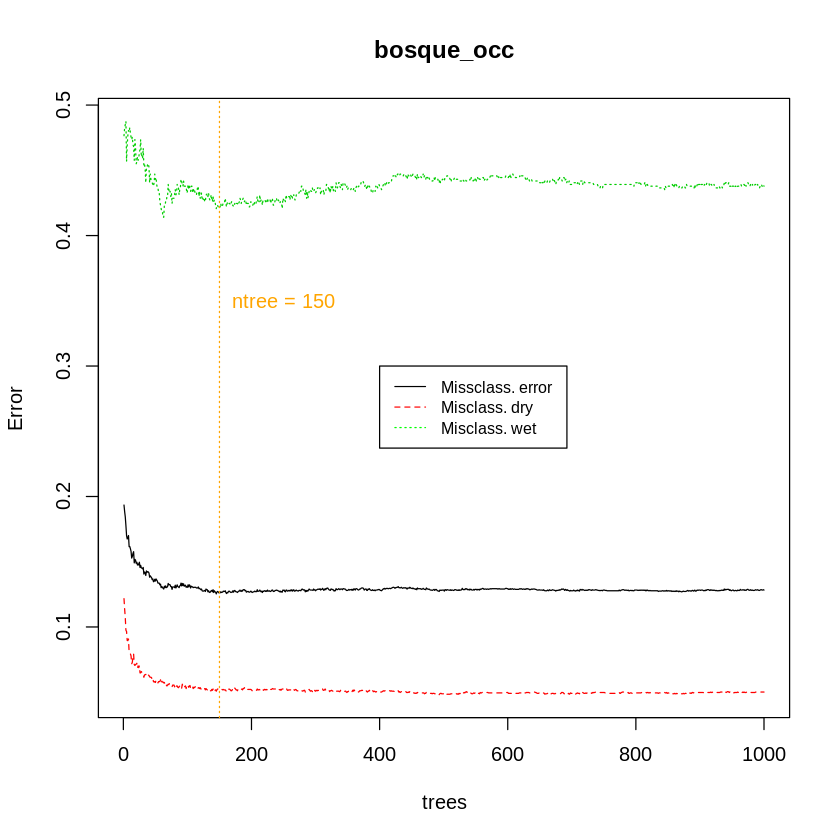

In [175]:
#::GMG::Gráfica OOB
#::nota::supongo que la curva roja es la clase '0' y la verde la clase '1'
#        y la negra es el misclassification error rate total
plot (bosque_occ)
legend(400, 0.3, legend=c("Missclass. error", "Misclass. dry", "Misclass. wet"),
       col=c("black","red", "green"), lty=1:3, cex=0.8)
abline(v = 150, lty = 3, col = 'orange')
text(250,0.35,'ntree = 150', col='orange')

**::GMG::** Parece que después de 150 árboles no se mejora el error ... así que me quedaría con 150

Utiliza el bosque de tamaño óptimo parar predecir la ocurrencia en el test, y conserva la predicción.

In [176]:
#::GMG::Hago el bosque con 100 árboles
## RF for occurrence (optimum)
bosque_occ_opt <- randomForest(
                        occurrence ~ .,
                        data = df_occ, subset = indtrain,
                        ntree = 150,
                        mtry = floor(sqrt(ncol(df_occ[,-1])))
)

In [177]:
print(bosque_occ_opt$confusion)

     0   1 class.error
0 2825 169  0.05644623
1  328 428  0.43386243


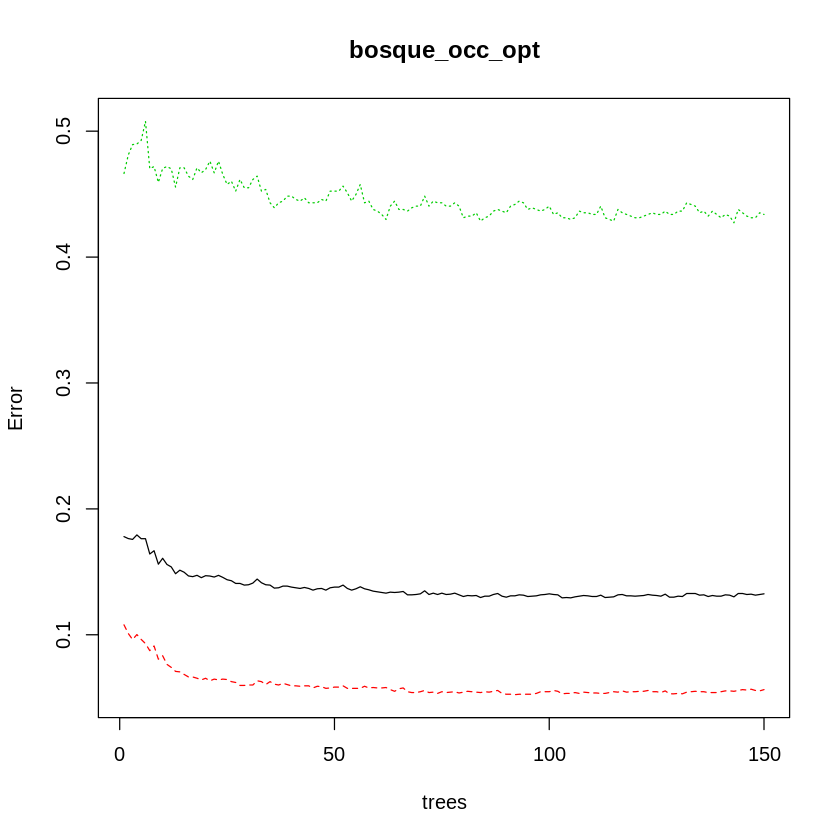

In [178]:
plot (bosque_occ_opt)
legend(400, 0.3, legend=c("Missclass. error", "Misclass. dry", "Misclass. wet"),
       col=c("black","red", "green"), lty=1:3, cex=0.8)

In [179]:
#::GMG::Hago la predicción
## occurrence prediction for test
# https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/predict.randomForest
#::nota::según la documentación, la puedo hacer en un solo paso con randomForest()
pred_bosque_occ <- predict(object = bosque_occ_opt, 
                           newdata = df_occ[indtest,],
                           type = 'class')

In [180]:
t_bosque_occ <- with(df_occ[indtest,],table(pred_bosque_occ,occurrence))
print(t_bosque_occ)

               occurrence
pred_bosque_occ   0   1
              0 938 113
              1  57 142


In [181]:
error_bosque_occ <- mean(pred_bosque_occ != df_occ[indtest,]$occurrence)
paste('RF Misclassification Error Rate (Test):', 100*error_bosque_occ, '%')

[1] "RF Misclassification Error Rate (Test): 13.6 %"

In [182]:
accuracy_bosque_occ <- sum(
    diag(table(pred_bosque_occ,df_occ[indtest,]$occurrence))
)/length(df_occ[indtest,]$occurrence)
paste('RF Accuracy (Test):', 100*accuracy_bosque_occ, '%')

[1] "RF Accuracy (Test): 86.4 %"

In [157]:
#::GMG::Recuerdo lo que obtuve sin RandomForest
#::nota::realmente la mejora es MUY marginal
print(t_occ)
paste('Occurence Misclassification Error Rate (Test):', 100*error_occ, '%')
paste('Occurrence Accuracy (Test):', 100*accuracy_occ, '%')

        occurrence
pred_occ   0   1
       0 925 125
       1  70 130


[1] "Occurence Misclassification Error Rate (Test): 15.6 %"

[1] "Occurrence Accuracy (Test): 84.4 %"

### Regresión RF

Seguidamente, tal y como hicimos con los árboles individuales, vamos a crear dos random forests para la cantidad, uno que se entrene sobre todo el dataset de train y otro que se entrene sólo sobre los días de lluvia (en el train). De nuevo, tendrás que estimar cuál es el número óptimo de árboles en cada uno de ellos (prueba bosques de hasta 1000 árboles). ¿Qué tamaños óptimos obtienes?

#### Dataset Precipitación

In [158]:
## RF 1 for amount (up to 1000 trees)
str(df_amount)

'data.frame':	5000 obs. of  38 variables:
 $ y   : num  10.9 0.6 13 0 0 1.2 1.1 0 0 0.7 ...
 $ X1  : num  57043 56963 56523 54628 53584 ...
 $ X2  : num  56535 56493 55971 53980 53391 ...
 $ X3  : num  55884 55931 55304 53494 53310 ...
 $ X4  : num  55176 55340 54498 53073 53293 ...
 $ X5  : num  54458 54769 53725 52616 53340 ...
 $ X6  : num  56980 56857 56515 54776 53782 ...
 $ X7  : num  56461 56362 55978 54089 53498 ...
 $ X8  : num  55800 55777 55327 53517 53307 ...
 $ X9  : num  55051 55164 54570 53013 53213 ...
 $ X10 : num  54319 54585 53863 52501 53157 ...
 $ X12 : num  56368 56187 55965 54205 53674 ...
 $ X13 : num  55721 55587 55360 53594 53378 ...
 $ X14 : num  54946 54947 54646 53021 53200 ...
 $ X15 : num  54145 54367 53999 52451 53055 ...
 $ X18 : num  55559 55360 55339 53657 53529 ...
 $ X19 : num  54788 54690 54720 53074 53260 ...
 $ X20 : num  53973 54125 54110 52486 53065 ...
 $ X24 : num  54555 54384 54695 53144 53383 ...
 $ X25 : num  53771 53843 54135 52556 53162 

In [160]:
bosque_amount <- randomForest(
                        y ~ .,
                        data = df_amount, subset = indtrain,
                        ntree = 1000,
                        mtry = max(floor(ncol(df_amount[,-1])/3), 1)
)

In [162]:
#::nota:: % var explained es 100 * R2 = 100 *(1 - SSE/SST)
bosque_amount


Call:
 randomForest(formula = y ~ ., data = df_amount, ntree = 1000,      mtry = max(floor(ncol(df_amount[, -1])/3), 1), subset = indtrain) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 12

          Mean of squared residuals: 24.41447
                    % Var explained: 26.83

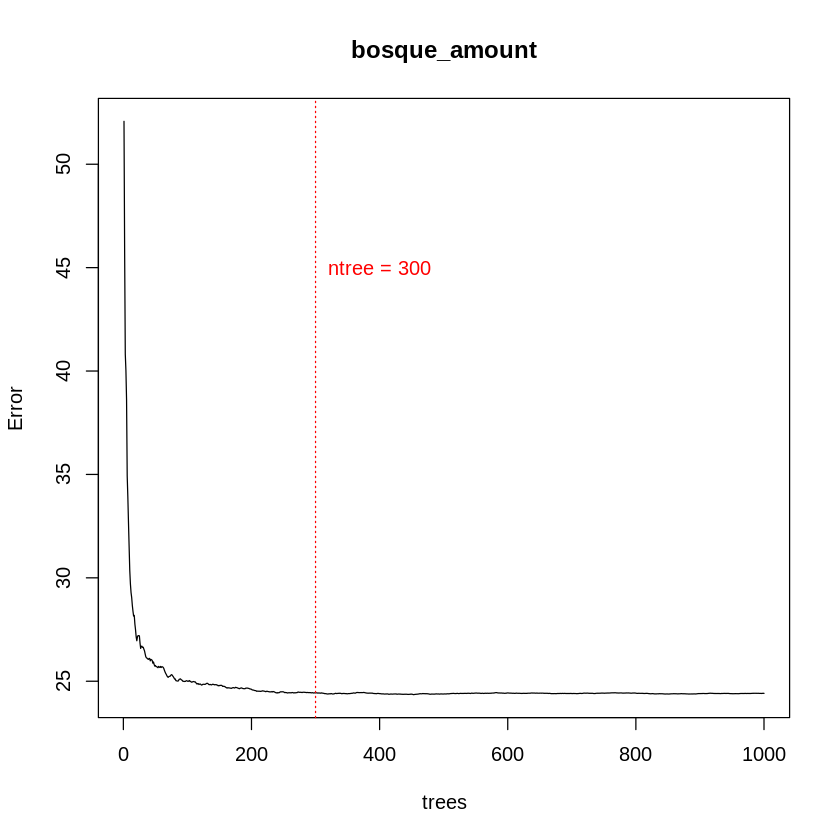

In [172]:
## plotting OOB (MSE) errors 
#::nota::pongo el corte de ntree óptimo
plot(bosque_amount)
abline(v = 300, lty = 3, col = 'red')
text(400,45,'ntree = 300', col='red')

In [167]:
## ntree óptimo
#::nota::Asumo 300 trees
bosque_amount_opt <- randomForest(
                        y ~ .,
                        data = df_amount, 
                        subset = indtrain,
                        ntree = 300,
                        mtry = max(floor(ncol(df_amount[,-1])/3), 1)
)

In [169]:
bosque_amount_opt


Call:
 randomForest(formula = y ~ ., data = df_amount, ntree = 300,      mtry = max(floor(ncol(df_amount[, -1])/3), 1), subset = indtrain) 
               Type of random forest: regression
                     Number of trees: 300
No. of variables tried at each split: 12

          Mean of squared residuals: 24.45213
                    % Var explained: 26.72

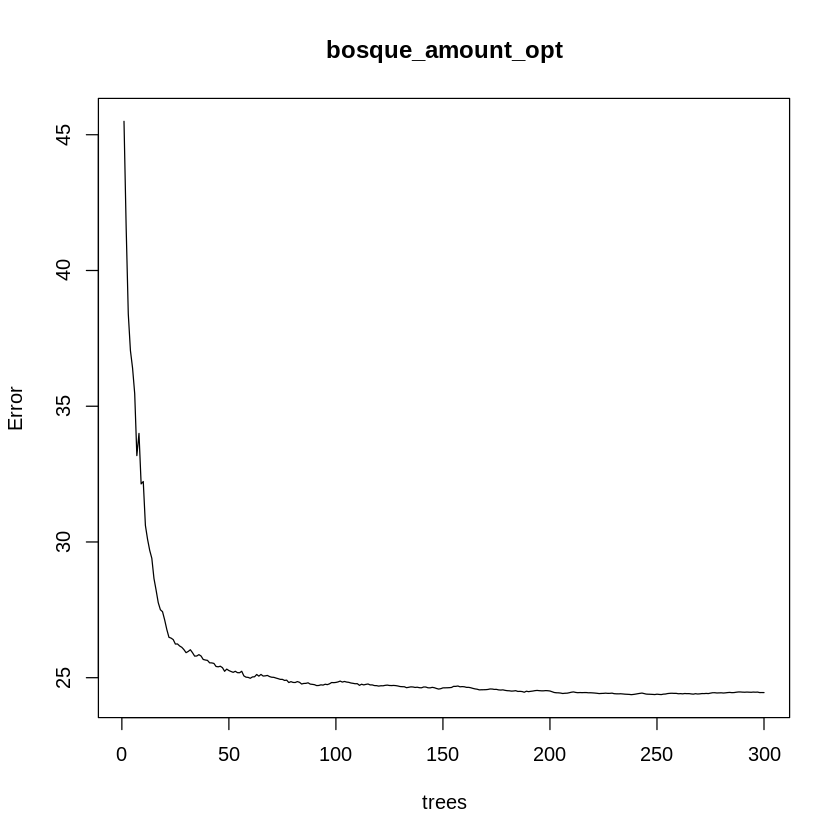

In [168]:
## plotting OOB errors
#::nota::igual se podía recortar un poco más incluso
plot(bosque_amount_opt)

#### Dataset Solo LLuvia (train)

In [384]:
## RF 2 for amount wet only (up to 1000 trees)
#::nota::abandono mi idea inicial de df_rainy y me centro en el subconjunto 
#        de train que tiene los días de lluvia
#str(df_rainy)
bosque_amount_rainy <- randomForest(
                        y ~ .,
                        data = df_amount[indtrain,], 
                        subset = df_amount$y[indtrain] >= 1,
                        ntree = 1000,
                        mtry = max(floor(ncol(df_amount[,-1])/3), 1)
)

In [385]:
bosque_amount_rainy


Call:
 randomForest(formula = y ~ ., data = df_amount[indtrain, ], ntree = 1000,      mtry = max(floor(ncol(df_amount[, -1])/3), 1), subset = df_amount$y[indtrain] >=          1) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 12

          Mean of squared residuals: 96.52653
                    % Var explained: 4.21

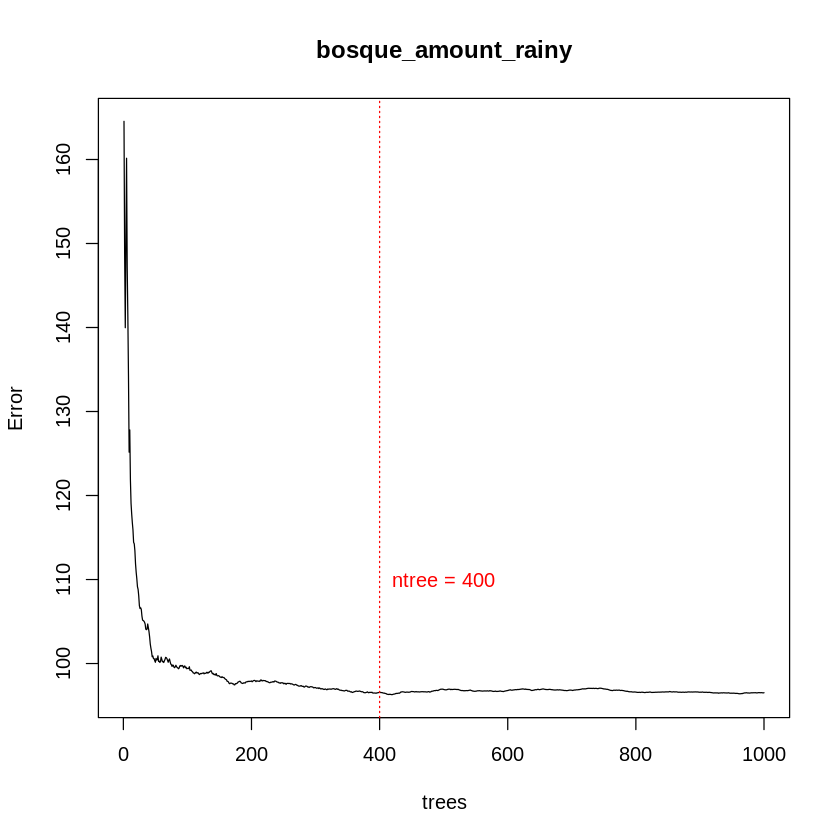

In [390]:
# plotting OOB errors
#::nota::pongo el corte de ntree óptimo
plot(bosque_amount_rainy)
abline(v = 400, lty = 3, col = 'red')
text(500,110,'ntree = 400', col='red')

In [392]:
## ntree óptimo
bosque_amount_rainy_opt <- randomForest(
                        y ~ .,
                        data = df_amount[indtrain, ], 
                        subset = df_amount$y[indtrain] >= 1,
                        ntree = 400,
                        mtry = max(floor(ncol(df_amount[,-1])/3), 1)
)

In [393]:
#::nota::el valor % Var explained es MUY bajo (!)
bosque_amount_rainy_opt


Call:
 randomForest(formula = y ~ ., data = df_amount[indtrain, ], ntree = 400,      mtry = max(floor(ncol(df_amount[, -1])/3), 1), subset = df_amount$y[indtrain] >=          1) 
               Type of random forest: regression
                     Number of trees: 400
No. of variables tried at each split: 12

          Mean of squared residuals: 96.36924
                    % Var explained: 4.37

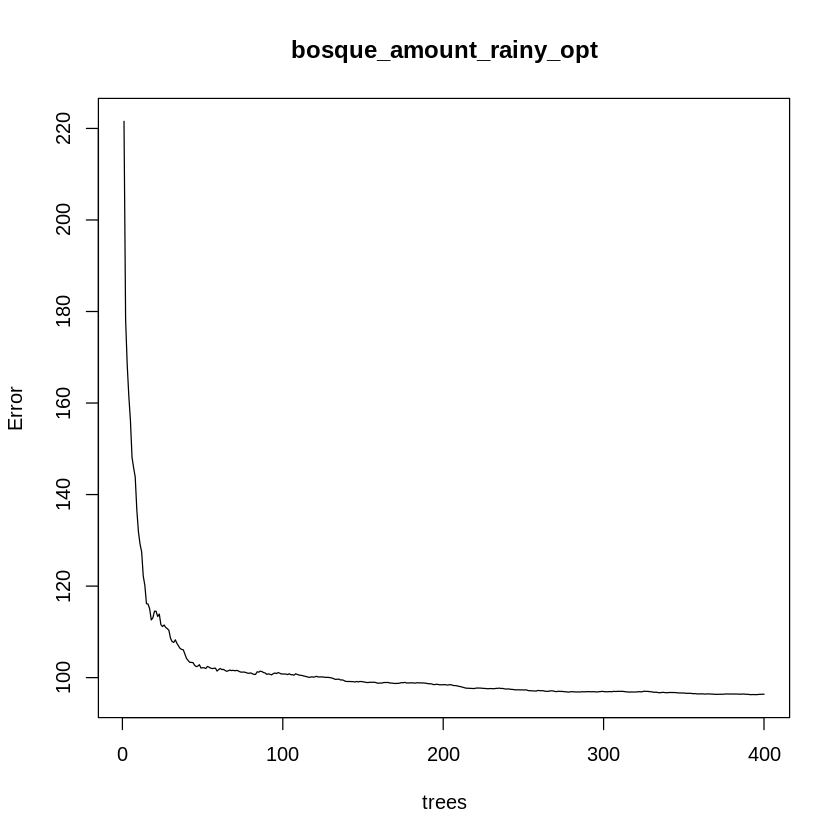

In [394]:
## plotting OOB errors
plot(bosque_amount_rainy_opt)

#### Predicción

Utiliza los bosques óptimos encontrados para predecir la cantidad en el test, y conserva las predicciones obtenidas.

In [395]:
## amount prediction for test
#::GMG::Predigo con el modelo RF con train completo
pred_bosque_amount <- predict(object = bosque_amount_opt, 
                              newdata = df_amount[indtest,])
#::GMG::Predigo con el modelo RF con train solo lluvia
pred_bosque_rainy <- predict(object = bosque_amount_rainy_opt, 
                              newdata = df_amount[indtest,])

### Validación

Construye las predicciones completas (ocurrencia * cantidad) de test y valídalas en función de las mismas métricas utilizadas en el apartado anterior.

#### Serie Completa (lluvia/no lluvia)

In [396]:
## final prediction
# https://stackoverflow.com/questions/3418128/how-to-convert-a-factor-to-integer-numeric-without-loss-of-information/
pred_final_rf_cp <- as.numeric(as.character(pred_bosque_occ)) * pred_bosque_amount

In [398]:
#::GMG::Calculo métricas
RMSE_amount_rf_final <- sqrt(mean((df_amount$y[indtest] - pred_final_rf_cp)^2))
paste('RMSE RF Final:', round(RMSE_amount_rf_final,2))

cor_amount_rf_final <- cor(df_amount$y[indtest], pred_final_rf_cp,  method = 'spearman')
paste('Spearman RF Final:', round(cor_amount_rf_final,2))

rv_amount_rf_final <- var(pred_final_rf_cp) / var(df_amount$y[indtest])
paste('Ratio Varianzas RF Final :', round(rv_amount_rf_final,2))

[1] "RMSE RF Final: 4.53"

[1] "Spearman RF Final: 0.57"

[1] "Ratio Varianzas RF Final : 0.38"

In [399]:
#::GMG::Resumen Test dataset amount
cbind(RMSE_amount_rf_final, cor_amount_rf_final, rv_amount_rf_final)

RMSE_amount_rf_final,cor_amount_rf_final,rv_amount_rf_final
4.527728,0.5745963,0.3807927


#### Serie Completa (Solo lluvia)

In [400]:
pred_final_rf_rainy <-  as.numeric(as.character(pred_bosque_occ)) * pred_bosque_rainy

In [402]:
#::GMG::Calculo métricas
RMSE_final_rf_rainy <- sqrt(mean((df_amount$y[indtest] - pred_final_rf_rainy)^2))
paste('Solo lluvia RMSE RF (Test):', round(RMSE_final_rf_rainy,2))

cor_final_rf_rainy <- cor(df_amount$y[indtest], pred_final_rf_rainy,  method = 'spearman')
paste('Solo lluvia Spearman RF:', round(cor_final_rf_rainy,2))

rv_final_rf_rainy <- var(pred_final_rf_rainy) / var(df_amount$y[indtest])
paste('Solo lluvia Ratio Varianzas RF:', round(rv_final_rainy,2))

[1] "Solo lluvia RMSE RF (Test): 4.62"

[1] "Solo lluvia Spearman RF: 0.57"

[1] "Solo lluvia Ratio Varianzas RF: 0.58"

In [403]:
#::GMG::Resumen Test dataset amount
cbind(RMSE_final_rf_rainy, cor_final_rf_rainy, rv_final_rf_rainy)

RMSE_final_rf_rainy,cor_final_rf_rainy,rv_final_rf_rainy
4.624692,0.5731436,0.6081435


#### Ocurrencia (Clasificación Lluvia/No Lluvia)

In [180]:
t_bosque_occ <- with(df_occ[indtest,],table(pred_bosque_occ,occurrence))
print(t_bosque_occ)

               occurrence
pred_bosque_occ   0   1
              0 938 113
              1  57 142


In [181]:
error_bosque_occ <- mean(pred_bosque_occ != df_occ[indtest,]$occurrence)
paste('RF Misclassification Error Rate (Test):', 100*error_bosque_occ, '%')

[1] "RF Misclassification Error Rate (Test): 13.6 %"

In [182]:
accuracy_bosque_occ <- sum(
    diag(table(pred_bosque_occ,df_occ[indtest,]$occurrence))
)/length(df_occ[indtest,]$occurrence)
paste('RF Accuracy (Test):', 100*accuracy_bosque_occ, '%')

[1] "RF Accuracy (Test): 86.4 %"

#### Más cosas

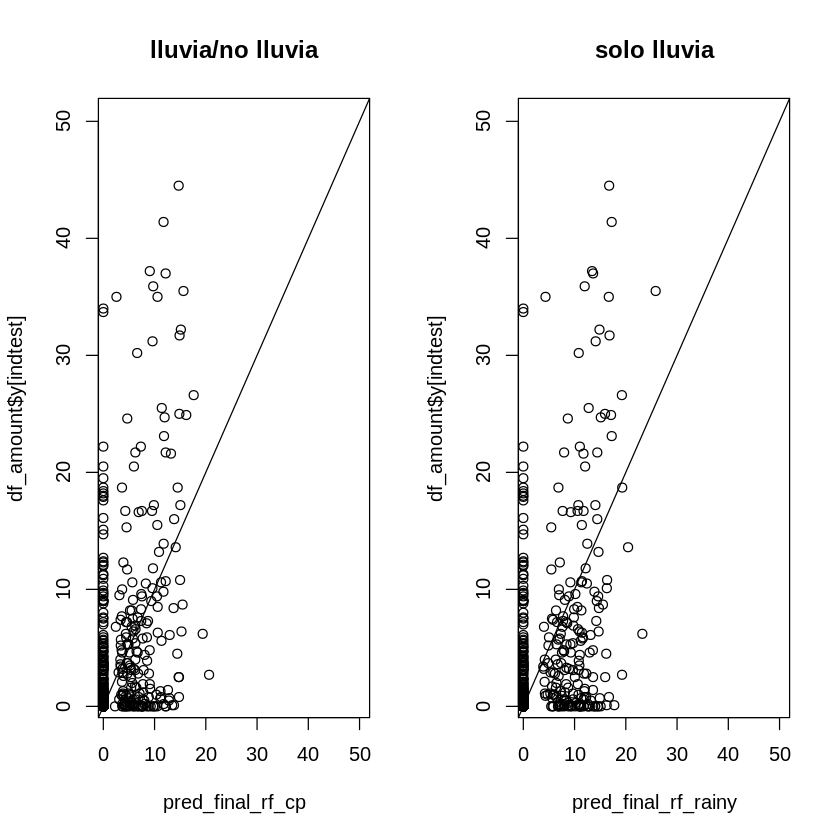

In [404]:
#::GMG::Veo cómo de buena es la predicción gráficamente
par(mfrow = c(1,2))
plot(pred_final_rf_cp,df_amount$y[indtest], 
     xlim = c(1,50), ylim = c(1,50),
     main = 'lluvia/no lluvia')

abline(0,1)
plot(pred_final_rf_rainy,df_amount$y[indtest], 
     xlim = c(1,50), ylim = c(1,50),
     main = 'solo lluvia')
abline(0,1)

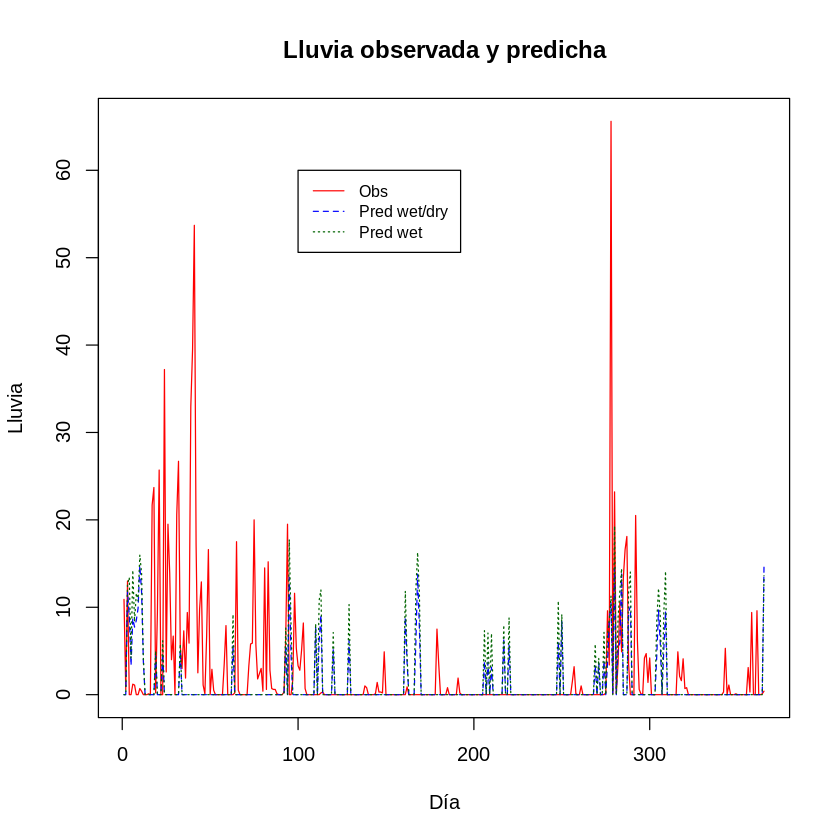

In [405]:
#::GMG::Ejemplo de lluvia observada y predicha (365 primeros días)
plot(df_amount$y[1:365], type = "l",col = "red", 
     xlab = "Día", lty = 1, ylab = "Lluvia", 
     main = "Lluvia observada y predicha")
lines(pred_final_rf_cp[1:365], 
      type = "l", lty = 2, col = "blue")
lines(pred_final_rf_rainy[1:365], 
      type = "l", lty = 3, col = "darkgreen")
legend(100, 60, legend=c("Obs", "Pred wet/dry", "Pred wet"),
       col=c("red", "blue", "darkgreen"), lty=1:3, cex=0.8)

### Conclusiones

**Pregunta:** Compara estos resultados con los obtenidos para árboles individuales. ¿Qué conclusiones obtienes de la comparación entre árboles individuales y random forests?

**::GMG::** El random forest aprovecha la técnica del resampling para intentar mejorar la clasificación (lluvia/no lluvia) y predicción (intesidad de lluvia) respecto a la técnica de árboles individuales. Sin embargo, las mejoras que he observado son bastante marginales. EL *RMSE* apenas se reduce (4.52, 4.62) mm. La clasificación apenas mejora un 2% su *accuracy*. Si se aprecia una mejora signficativa de la clasificación del evento de lluvia (*recall*) que pasa al **71%** pero es claramente insuficiente. De nuevo el efecto combinado de clasificación y regresión (serie completa) de la varianza necesaria como para prdecir adecuadamente la intensidad (0.38, 0.60), incluyendo los eventos extremos.

## Punto 3: Modelos lineales generalizados (GLMs)
### (1.5 puntos)

Usaremos a continuación GLMs para el mismo problema abordado en los apartados anteriores. Como ya hemos visto en otras sesiones, debemos utilizar la familia *binomial* con función de enlace *logit* (regresión logística) para clasificación y la familia *Gamma* con función de enlace *log* para la cantidad. 

Comenzamos con el modelo para la ocurrencia.

### Ocurrencia

In [409]:
#::GMG::Como siempre compruebo mi dataset de ocurrencia
#::nota::conservo mi train/test
str(df_occ)
str(indtest)
str(indtrain)

'data.frame':	5000 obs. of  38 variables:
 $ occurrence: Factor w/ 2 levels "0","1": 2 1 2 1 1 2 2 1 1 1 ...
 $ X1        : num  57043 56963 56523 54628 53584 ...
 $ X2        : num  56535 56493 55971 53980 53391 ...
 $ X3        : num  55884 55931 55304 53494 53310 ...
 $ X4        : num  55176 55340 54498 53073 53293 ...
 $ X5        : num  54458 54769 53725 52616 53340 ...
 $ X6        : num  56980 56857 56515 54776 53782 ...
 $ X7        : num  56461 56362 55978 54089 53498 ...
 $ X8        : num  55800 55777 55327 53517 53307 ...
 $ X9        : num  55051 55164 54570 53013 53213 ...
 $ X10       : num  54319 54585 53863 52501 53157 ...
 $ X12       : num  56368 56187 55965 54205 53674 ...
 $ X13       : num  55721 55587 55360 53594 53378 ...
 $ X14       : num  54946 54947 54646 53021 53200 ...
 $ X15       : num  54145 54367 53999 52451 53055 ...
 $ X18       : num  55559 55360 55339 53657 53529 ...
 $ X19       : num  54788 54690 54720 53074 53260 ...
 $ X20       : num  53973 5

In [410]:
#::GMG::Obtengo el modelo de clasificación por regresión logística de la ocurrencia
# https://stat.ethz.ch/R-manual/R-devel/library/stats/html/glm.html
# https://www.statmethods.net/advstats/glm.html
## GLM for occurrence
glm_occ <- glm(formula = occurrence ~., 
               data = df_occ, 
               subset = indtrain, 
               family = binomial (link = 'logit')
              )

In [412]:
#::GMG::Modelo que he obtenido
# https://www.statmethods.net/advstats/glm.html
#::nota::no todos los coeficientes obtenidos son significativos (p = 0.05)
summary(glm_occ) # display results


Call:
glm(formula = occurrence ~ ., family = binomial(link = "logit"), 
    data = df_occ, subset = indtrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3724  -0.4189  -0.2007  -0.0822   2.8484  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.296e+02  4.338e+01   5.293 1.20e-07 ***
X1           3.870e-03  2.259e-03   1.713 0.086700 .  
X2          -5.520e-03  5.325e-03  -1.037 0.299864    
X3           3.578e-03  6.651e-03   0.538 0.590625    
X4           7.133e-03  6.027e-03   1.183 0.236645    
X5          -8.125e-03  3.570e-03  -2.276 0.022853 *  
X6          -3.779e-03  2.355e-03  -1.605 0.108577    
X7           3.717e-03  6.509e-03   0.571 0.567920    
X8          -6.874e-05  9.664e-03  -0.007 0.994325    
X9          -1.522e-02  1.099e-02  -1.384 0.166213    
X10          1.554e-02  8.586e-03   1.810 0.070226 .  
X12          2.017e-03  3.572e-03   0.565 0.572295    
X13         -5.319e-04  7.841e-03  -0.068 0.9

In [414]:
#::GMG::Otras cosas que se pueden ver (con tiempo)
#confint(glm_occ) # 95% CI for the coefficients
#exp(coef(glm_occ)) # exponentiated coefficients
#exp(confint(glm_occ)) # 95% CI for exponentiated coefficients

Una vez tenemos el modelo, lo utilizamos para predecir en el test. Tendremos que convertir la predicción probabilística obtenida en binaria (considera un umbral 0.5).

In [416]:
#::GMG::Hago la predicción probabilística y la transformo en binaria
#       con umbral 0.5
## occurrence prediction for test
pred_glm_occ_p <- predict(object = glm_occ, 
                          newdata = df_occ[indtest,], 
                          type = 'response')
pred_glm_occ <- ifelse(pred_glm_occ_p >= 0.5, 1, 0)
str(pred_glm_occ)

 Named num [1:1250] 0 0 1 1 1 1 0 1 1 1 ...
 - attr(*, "names")= chr [1:1250] "1" "7" "19" "24" ...


In [417]:
#::GMG::Obtengo las métricas del modelo
accuracy_glm <- sum(diag(table(pred_glm_occ, df_occ$occurrence[indtest]))) / length(indtest)
paste('GLM Accuracy:', round(accuracy_glm, 2))

[1] "GLM Accuracy: 0.86"

### Precipitación

A continuación, ajustamos el modelo de cantidad. Para ello tenemos que seleccionar previamente los días de lluvia (la familia Gamma sólo acepta valores positivos). 

In [418]:
#::GMG::Tengo mi dataset de precipitación ya montado con sus índices de train/test
str(df_amount)
str(indtest)
str(indtrain)

'data.frame':	5000 obs. of  38 variables:
 $ y   : num  10.9 0.6 13 0 0 1.2 1.1 0 0 0.7 ...
 $ X1  : num  57043 56963 56523 54628 53584 ...
 $ X2  : num  56535 56493 55971 53980 53391 ...
 $ X3  : num  55884 55931 55304 53494 53310 ...
 $ X4  : num  55176 55340 54498 53073 53293 ...
 $ X5  : num  54458 54769 53725 52616 53340 ...
 $ X6  : num  56980 56857 56515 54776 53782 ...
 $ X7  : num  56461 56362 55978 54089 53498 ...
 $ X8  : num  55800 55777 55327 53517 53307 ...
 $ X9  : num  55051 55164 54570 53013 53213 ...
 $ X10 : num  54319 54585 53863 52501 53157 ...
 $ X12 : num  56368 56187 55965 54205 53674 ...
 $ X13 : num  55721 55587 55360 53594 53378 ...
 $ X14 : num  54946 54947 54646 53021 53200 ...
 $ X15 : num  54145 54367 53999 52451 53055 ...
 $ X18 : num  55559 55360 55339 53657 53529 ...
 $ X19 : num  54788 54690 54720 53074 53260 ...
 $ X20 : num  53973 54125 54110 52486 53065 ...
 $ X24 : num  54555 54384 54695 53144 53383 ...
 $ X25 : num  53771 53843 54135 52556 53162 

In [419]:
#::GMG::Obtengo el modelo GLM de precipitación pero solamente para días de lluvia
# https://stat.ethz.ch/R-manual/R-devel/library/base/html/sets.html
# https://stat.ethz.ch/R-manual/R-devel/library/base/html/which.html
#::DUDA::No veo muy claro lo de los "valores positivos" de Gamma en relación con la
#        cantidad de precipitación
# https://en.wikipedia.org/wiki/Gamma_distribution
## GLM for amount
glm_amount <- glm(formula = y ~., 
                       data = df_amount, 
                       subset = intersect(indtrain, which(df_amount$y >= 1)), 
                       family = Gamma (link = 'log'))

In [420]:
#::GMG::Modelo que he obtenido
# https://www.statmethods.net/advstats/glm.html
#::nota::aquí de nuevo muy pocos coeficientes significativos (p = 0.05)
summary(glm_amount) # display results
#confint(glm_amount) # 95% CI for the coefficients
#exp(coef(glm_amount)) # exponentiated coefficients
#exp(confint(glm_amount)) # 95% CI for exponentiated coefficients


Call:
glm(formula = y ~ ., family = Gamma(link = "log"), data = df_amount, 
    subset = intersect(indtrain, which(df_amount$y >= 1)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7708  -0.8805  -0.2830   0.3319   3.0492  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 29.9764780 29.7020084   1.009 0.313199    
X1           0.0021773  0.0013206   1.649 0.099646 .  
X2          -0.0025098  0.0028345  -0.885 0.376207    
X3           0.0005767  0.0033862   0.170 0.864823    
X4          -0.0022130  0.0030402  -0.728 0.466906    
X5          -0.0010566  0.0018012  -0.587 0.557658    
X6          -0.0009931  0.0014454  -0.687 0.492261    
X7           0.0007321  0.0036055   0.203 0.839165    
X8           0.0054757  0.0051838   1.056 0.291184    
X9           0.0046753  0.0056261   0.831 0.406250    
X10          0.0001290  0.0043965   0.029 0.976599    
X12         -0.0001369  0.0021758  -0.063 0.949837    
X13         -0.00779

Utilizamos el modelo obtenido para predecir la cantidad en el test.

In [421]:
#::GMG::Predigo la precipitación con el modelo obtenido
## amount prediction for test
pred_glm_amount <- predict(object = glm_amount, 
                           newdata = df_amount[indtest,], 
                           type = 'response')
str(pred_glm_amount)

 Named num [1:1250] 6.57 6.94 7.6 12.61 3.86 ...
 - attr(*, "names")= chr [1:1250] "1" "7" "19" "24" ...


#### Serie completa

De nuevo, multiplicamos la ocurrencia por la cantidad para obtener la predicción completa en el test y la validamos en función de las métricas de validación que utilizamos para CART y random forests.

In [422]:
#::GMG::Obtengo la 'serie completa'
# final prediction for test
pred_glm_final <- pred_glm_occ * pred_glm_amount
str(pred_glm_final)

 Named num [1:1250] 0 0 7.6 12.61 3.86 ...
 - attr(*, "names")= chr [1:1250] "1" "7" "19" "24" ...


#### Validación

In [423]:
#::GMG::Valido con las métricas de regresión y clasificación
# validation
RMSE_final_glm <- sqrt(mean((df_amount$y[indtest] - pred_glm_final)^2))
paste('RMSE GLM (Test):', round(RMSE_final_glm,2))

cor_final_glm <- cor(df_amount$y[indtest], pred_glm_final,  method = 'spearman')
paste('Spearman GLM:', round(cor_final_glm,2))

rv_final_glm <- var(pred_glm_final) / var(df_amount$y[indtest])
paste('Ratio Varianzas GLM:', round(rv_final_glm,2))

[1] "RMSE GLM (Test): 4.7"

[1] "Spearman GLM: 0.57"

[1] "Ratio Varianzas GLM: 0.69"

In [424]:
#::GMG::Resumen Test dataset amount
cbind(RMSE_final_glm, cor_final_glm, rv_final_glm)

RMSE_final_glm,cor_final_glm,rv_final_glm
4.696362,0.5715546,0.688561


In [426]:
error_glm_occ <- mean(pred_glm_occ != df_occ[indtest,]$occurrence)
paste('GLM Misclassification Error Rate (Test):', 100*error_glm_occ, '%')

[1] "GLM Misclassification Error Rate (Test): 14.24 %"

In [427]:
accuracy_glm_occ <- sum(
    diag(table(pred_glm_occ,df_occ[indtest,]$occurrence))
)/length(df_occ[indtest,]$occurrence)
paste('GLM Accuracy (Test):', 100*accuracy_glm_occ, '%')

[1] "GLM Accuracy (Test): 85.76 %"

#### Más cosas

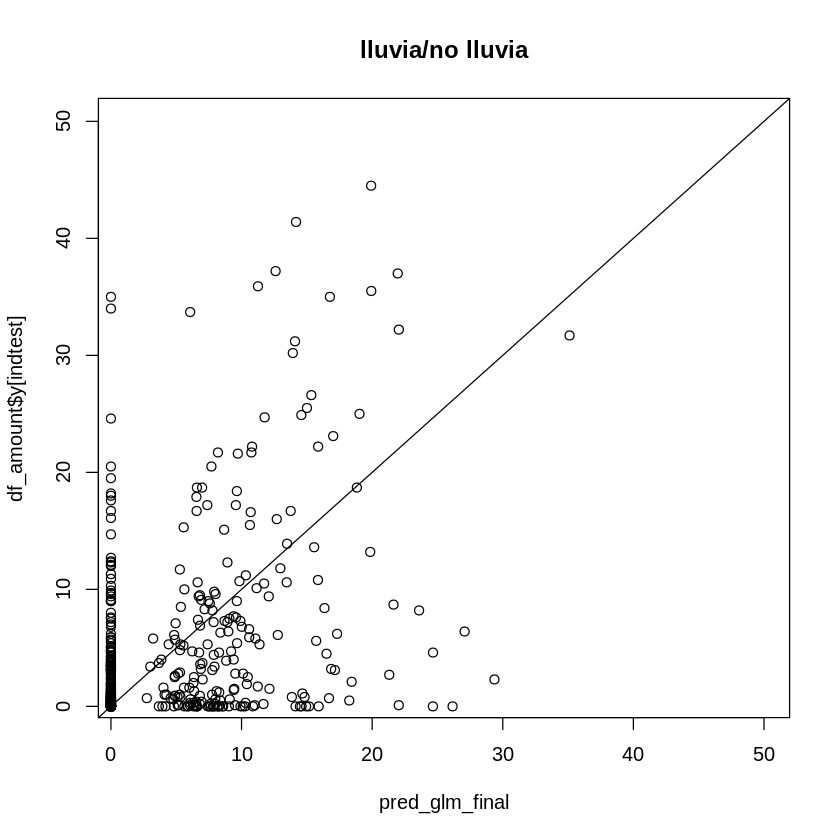

In [428]:
#::GMG::Veo cómo de buena es la predicción gráficamente
plot(pred_glm_final,df_amount$y[indtest], 
     xlim = c(1,50), ylim = c(1,50),
     main = 'lluvia/no lluvia')

abline(0,1)

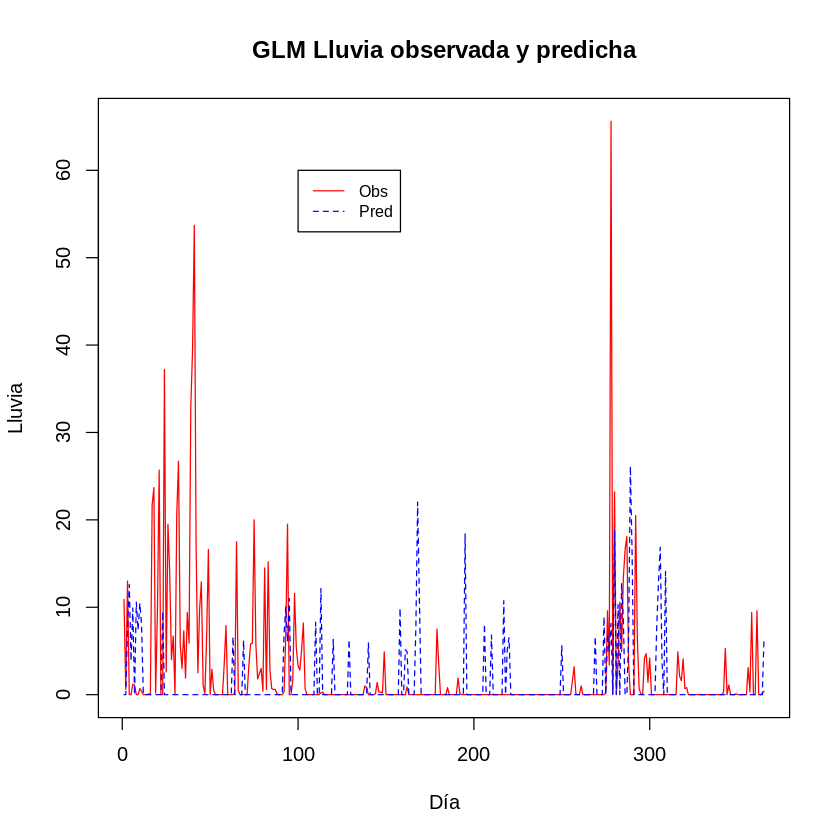

In [429]:
#::GMG::Ejemplo de lluvia observada y predicha (365 primeros días)
plot(df_amount$y[1:365], type = "l",col = "red", 
     xlab = "Día", lty = 1, ylab = "Lluvia", 
     main = "GLM Lluvia observada y predicha")
lines(pred_glm_final[1:365], 
      type = "l", lty = 2, col = "blue")
legend(100, 60, legend=c("Obs", "Pred"),
       col=c("red", "blue"), lty=1:2, cex=0.8)

### Conclusiones

**Pregunta:** Compara estos resultados con los obtenidos para CART y random forests. ¿Qué conclusiones obtienes?

**::GMG::** La clasificación con GLM no ofrece una mejora en la clasificación del evento lluvia/no lluvia con un *accuracy* similar (inferior) de **85.75%** respecto al RF y similar (superior) a CART. El ratio de varianza es el mayor (aunque marginalmente) con **0.68** respecto a los otros dos modelos pero no hace que la predicción de la intensidad de lluvia mejore (se puede apreciar de nuevo en la gráficas de predicción). El *RMSE* es similar que en los otros dos modelos (especialmente el RF), con **4.69 mm**. 

Quiero destacar también, aunque todavía no soy capaz de interpretarlo cuantitativamente (nos han dado base estadística en M1965 que estoy asimilando) que el GLM ofrece unos coeficientes de las features seleccionadas muy poco significativos (p = 0.05) y gran error (std error) con una gran intercept. Esto puede indicar que el modelo no está bien ajustado (¿underfit?).

## Punto 4: k nearest neighbors (k-NN)
### (1.5 puntos)

La última de las técnicas a utilizar será la k-NN (ten en cuenta que en este caso ya no tendremos que predecir por separado ocurrencia y cantidad). Comenzaremos por una versión de k-NN en la que sólo se considere el vecino más cercano (utiliza la función *knn.reg* del paquete *FNN*). 

**Nota:** Recuerda que en la técnica k-NN es muy importante pre-procesar adecuadamente (estandarizar) los predictores.

In [451]:
#::GMG::Aquí uso solamente el dataset de precipitación y sus índices train/test
str(df_amount)
str(indtrain)
str(indtest)

'data.frame':	5000 obs. of  38 variables:
 $ y   : num  10.9 0.6 13 0 0 1.2 1.1 0 0 0.7 ...
 $ X1  : num  57043 56963 56523 54628 53584 ...
 $ X2  : num  56535 56493 55971 53980 53391 ...
 $ X3  : num  55884 55931 55304 53494 53310 ...
 $ X4  : num  55176 55340 54498 53073 53293 ...
 $ X5  : num  54458 54769 53725 52616 53340 ...
 $ X6  : num  56980 56857 56515 54776 53782 ...
 $ X7  : num  56461 56362 55978 54089 53498 ...
 $ X8  : num  55800 55777 55327 53517 53307 ...
 $ X9  : num  55051 55164 54570 53013 53213 ...
 $ X10 : num  54319 54585 53863 52501 53157 ...
 $ X12 : num  56368 56187 55965 54205 53674 ...
 $ X13 : num  55721 55587 55360 53594 53378 ...
 $ X14 : num  54946 54947 54646 53021 53200 ...
 $ X15 : num  54145 54367 53999 52451 53055 ...
 $ X18 : num  55559 55360 55339 53657 53529 ...
 $ X19 : num  54788 54690 54720 53074 53260 ...
 $ X20 : num  53973 54125 54110 52486 53065 ...
 $ X24 : num  54555 54384 54695 53144 53383 ...
 $ X25 : num  53771 53843 54135 52556 53162 

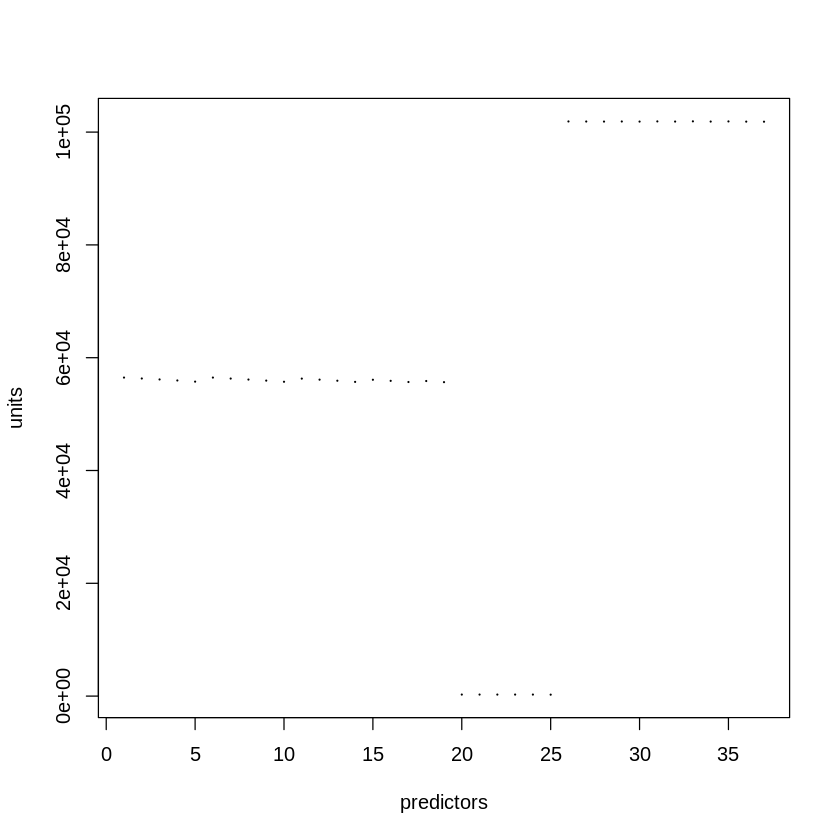

In [454]:
#::GMG::La advertencia sobre el escalado se puede ver en el str ya
#       También se puede ver de forma gráfica
plot(colMeans(df_amount[,-1]), cex = 0.1, xlab = "predictors", ylab = "units")

In [466]:
#::GMG::Escalo los predictores en primer lugar pues
df_amount_scaled <- as.data.frame(
    cbind(df_amount$y, scale(df_amount[,-1]))
)
colnames(df_amount_scaled)[1] <- 'precip'
str(df_amount_scaled)

'data.frame':	5000 obs. of  38 variables:
 $ precip: num  10.9 0.6 13 0 0 1.2 1.1 0 0 0.7 ...
 $ X1    : num  0.523 0.449 0.042 -1.71 -2.675 ...
 $ X2    : num  0.195 0.159 -0.3 -2.05 -2.567 ...
 $ X3    : num  -0.218 -0.179 -0.705 -2.225 -2.379 ...
 $ X4    : num  -0.632 -0.5 -1.175 -2.319 -2.142 ...
 $ X5    : num  -0.992 -0.755 -1.553 -2.4 -1.847 ...
 $ X6    : num  0.4568 0.3445 0.0343 -1.5442 -2.447 ...
 $ X7    : num  0.1375 0.0522 -0.28 -1.9132 -2.4242 ...
 $ X8    : num  -0.269 -0.288 -0.661 -2.16 -2.334 ...
 $ X9    : num  -0.704 -0.614 -1.087 -2.323 -2.164 ...
 $ X10   : num  -1.077 -0.874 -1.423 -2.459 -1.96 ...
 $ X12   : num  0.0646 -0.089 -0.2775 -1.7731 -2.2241 ...
 $ X13   : num  -0.317 -0.426 -0.611 -2.054 -2.231 ...
 $ X14   : num  -0.764 -0.763 -1 -2.279 -2.138 ...
 $ X15   : num  -1.19 -1.02 -1.3 -2.47 -2.01 ...
 $ X18   : num  -0.426 -0.587 -0.604 -1.958 -2.06 ...
 $ X19   : num  -0.863 -0.939 -0.916 -2.199 -2.054 ...
 $ X20   : num  -1.29 -1.18 -1.19 -2.41 -1.98 .

In [471]:
#::GMG::Cargo la primera biblioteca a usar
#https://www.rdocumentation.org/packages/FNN/versions/1.1.2.2
library('FNN')

In [473]:
#::GMG::Ahora que tengo listo el dataset hago una predicción
## prediction for test (with k = 1)
# https://www.rdocumentation.org/packages/FNN/versions/1.1.2.2/topics/knn.reg
pred_knn_amount <- knn.reg(train = df_amount_scaled[indtrain, -1], 
                           test = df_amount_scaled[indtest, -1], 
                           y = df_amount_scaled[indtrain, 1], 
                           k = 1)

In [476]:
#::GMG::Resultado obtenido
str(pred_knn_amount)

List of 7
 $ call     : language knn.reg(train = df_amount_scaled[indtrain, -1], test = df_amount_scaled[indtest,      -1], y = df_amount_scaled[i| __truncated__
 $ k        : num 1
 $ n        : int 1250
 $ pred     : num [1:1250] 0 0 2 45.2 3.7 28.1 5.5 0 5.4 19.4 ...
 $ residuals: NULL
 $ PRESS    : NULL
 $ R2Pred   : NULL
 - attr(*, "class")= chr "knnReg"


In [486]:
#::GMG::Calculo métricas
rmse_knn <- sqrt(mean((df_amount_scaled$precip[indtest] - pred_knn_amount$pred)^2))
paste('KNN RMSE (Test):', round(rmse_knn,2))

cor_knn <- cor(df_amount_scaled$precip[indtest], 
               pred_knn_amount$pred,  
               method = 'spearman')
paste('Spearman KNN:', round(cor_knn,2))

rv_knn <- var(pred_knn_amount$pred) / var(df_amount_scaled$precip[indtest])
paste('Ratio Varianzas KNN:', round(rv_knn,2))

t_knn <- with(df_amount_scaled[indtest,],
              table(ifelse(pred_knn_amount$pred >= 1, 1, 0),
                    ifelse(precip >= 1, 1, 0)
                   )
             )
print(t_knn)

accuracy_knn <- sum(
    diag(table(ifelse(pred_knn_amount$pred >= 1, 1, 0),
                ifelse(df_amount_scaled[indtest, 1] >= 1, 1, 0))))/length(indtest)
paste('Accuracy KNN (Test):', 100*accuracy_knn, '%')

[1] "KNN RMSE (Test): 5.57"

[1] "Spearman KNN: 0.53"

[1] "Ratio Varianzas KNN: 0.89"

   
      0   1
  0 890 117
  1 105 138


[1] "Accuracy KNN (Test): 82.24 %"

Como vimos en su día, el único parámetro a ajustar en la técnica k-NN es k (número de vecinos). Utilizaremos el paquete *caret* para encontrar el k óptimo en nuestro problema. Para ello, considera una cross-validación con 10 folds sobre el dataset de train y barre todos los k impares desde 1 a 50.

In [489]:
#::GMG::Cargo la biblioteca que hay que usar
library(caret)

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin



In [490]:
## finding optimum k
## fitting model with caret
#::GMG::Fijo el entrenamiento 10-fold CV
trctrl = trainControl(method = "cv", number = 10)
#::GMG::Ejecuto el entrenamiento con knn, el traincontrol y buscando
#       el k óptimo entre los impares (seq) de 1 a 50
knn_fit = train(precip ~ ., df_amount_scaled[indtrain,],
                method = "knn",
                trControl = trctrl,
                #::nota::Yo ya lo he hecho
                #preProcess = c("center", "scale"),
                tuneGrid = expand.grid(k = seq(1,50,2)))

In [530]:
str(knn_fit$results)

'data.frame':	25 obs. of  7 variables:
 $ k         : num  1 3 5 7 9 11 13 15 17 19 ...
 $ RMSE      : num  6.68 5.61 5.34 5.18 5.09 ...
 $ Rsquared  : num  0.0928 0.1638 0.1881 0.2134 0.228 ...
 $ MAE       : num  2.35 2.14 2.09 2.02 2 ...
 $ RMSESD    : num  1.352 0.903 0.987 0.973 0.982 ...
 $ RsquaredSD: num  0.0498 0.0608 0.0692 0.0661 0.0643 ...
 $ MAESD     : num  0.321 0.235 0.221 0.205 0.219 ...


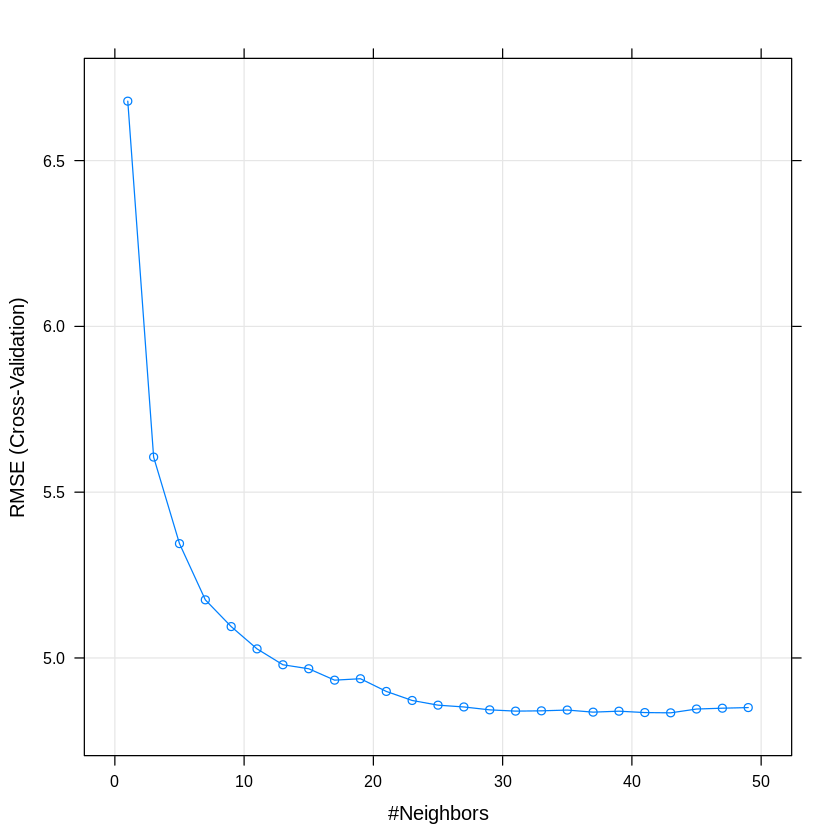

In [498]:
#::GMG::Muestro gráficamente el resultado
plot(knn_fit)

In [528]:
#::GMG::K óptimo según Caret
#::nota::dada la zona plana de RMSE a partir de 27, podría coger un modelo más simple
paste('K óptimo:', knn_fit$bestTune, 
      '-- RMSE (K óptimo):', 
      round(knn_fit$results$RMSE[which (knn_fit$results$k == knn_fit$bestTune[[1]])],2))

[1] "K óptimo: 43 -- RMSE (K óptimo): 4.83"

Utiliza este *k* óptimo para predecir en el test.

In [531]:
#::GMG::Hago la predicción
#::nota::por lo visto el modelo de caret se toma con el k óptimo de bestTune
# prediction for test (with optimum k)
pred_knn_opt <- predict(object = knn_fit, df_amount_scaled[indtest, -1])

Valida las dos predicciones (con *k=1* y con *k=óptimo*) en el test, en función de las medidas que se han ido utilizando en los apartados anteriores.

In [534]:
#Calculo las métricas del óptimo y comparo con el 43-nn
# validation
rmse_knn_opt <- sqrt(mean((df_amount_scaled$precip[indtest] - pred_knn_opt)^2))
paste('43-NN RMSE Optimo (Test):', round(rmse_knn_opt,2))

cor_knn_opt <- cor(df_amount_scaled$precip[indtest], 
               pred_knn_opt,  
               method = 'spearman')
paste('Spearman 43-NN Optimo:', round(cor_knn_opt,2))

rv_knn_opt <- var(pred_knn_opt) / var(df_amount_scaled$precip[indtest])
paste('Ratio Varianzas 43-NN Optimo:', round(rv_knn_opt,2))

t_knn_opt <- with(df_amount_scaled[indtest,],
              table(ifelse(pred_knn_opt >= 1, 1, 0),
                    ifelse(precip >= 1, 1, 0)
                   )
             )
print(t_knn_opt)

accuracy_knn_opt <- sum(
    diag(table(ifelse(pred_knn_opt >= 1, 1, 0),
                ifelse(df_amount_scaled[indtest, 1] >= 1, 1, 0))))/length(indtest)
paste('Accuracy 43-NN Optimo (Test):', 100*accuracy_knn_opt, '%')

[1] "43-NN RMSE Optimo (Test): 4.5"

[1] "Spearman 43-NN Optimo: 0.6"

[1] "Ratio Varianzas 43-NN Optimo: 0.24"

   
      0   1
  0 727  35
  1 268 220


[1] "Accuracy 43-NN Optimo (Test): 75.76 %"

In [488]:
#::GMG::Resumen 1-NN
cbind(rmse_knn, cor_knn, rv_knn, accuracy_knn)

rmse_knn,cor_knn,rv_knn,accuracy_knn
5.570832,0.5332599,0.8888995,0.8224


In [533]:
#::GMG::Resumen 43-NN (opt)
cbind(rmse_knn_opt, cor_knn_opt, rv_knn_opt, accuracy_knn_opt)

rmse_knn_opt,cor_knn_opt,rv_knn_opt,accuracy_knn_opt
4.49616,0.6011555,0.2377397,0.7576


**Pregunta:** ¿Qué diferencias obtienes entre las dos versiones utilizadas de la técnica k-NN? ¿A qué se deben?

**::GMG::** Aquí vemos que el uso de muchos más vecinos para determinar la predicción lleva a una reducción de RMSE (que por otra parte era el objetivo d ela optimización de caret) y el incremento de la correlación pero *cae dramáticamente* el ratio de varianzas y el *accuracy* de clasificación del evento lluvia. Esto lo hace totalmente incapaz a 43-NN de predecir eventos, y no ya extremos sino más allá de una estrecha banda de valores de precipitación. Creo que el modelo está claramente en *overfit* en relación al ratio de varianzas y el *accuracy* y quizá con un modelo más simple (K inferior) podría obtener un mejor ratio y clasificación.

## Punto 5: Conclusiones generales
### (2 puntos)
A la vista de los resultados obtenidos, argumenta razonadamete qué técnica o técnicas serían las mejores para la predicción de lluvia en Lisboa. Justifica tu respuesta.

**::GMG::** No soy un experto en meteo así que las conclusiones que aquí expongo pueden estar completamente equivocadas. Mi conclusión es que ninguno de los modelos que he construido ha sabido clasificar de forma satosfcatoria el evento lluvia o predecir de forma satisfactoria la precipitación (incluyendo intensidades más o menos extremas). Esto se puede deber a diferentes factores que han llevado a los modelos a la zonas de *unerfit* u *overfit*. La selección inicial de variables y la limitación en el tamaño de la muestra a 5000 tienen sin duda su influencia en los resultados. Una selección de variables (*feature selection*) más rigurosa incluyendo conocimiento del dominio del problema y/o técnicas alternativas (creo recordar que una práctica de KNN se usó PCA y varias métricas para la optimización, por ejemplo) mejorarían los resultados.